<a href="https://colab.research.google.com/github/PrathamSoni4473/Mumbai-AQI-Forecast/blob/master/Ensemble_STL_CNN_LSTM_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Libraries

In [1]:
import pandas as pd
# from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# from tensorflow.keras.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import tensorflow as tf
import numpy as np
from pandas.tseries.offsets import DateOffset
import seaborn as sns
mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from tensorflow.keras.layers import LSTM, Dense, Dropout, SimpleRNN, ConvLSTM2D,Input, RepeatVector,TimeDistributed,Conv1D, MaxPooling1D
from matplotlib import rcParams
import pywt

# Ignore all warnings
warnings.filterwarnings("ignore")

### Retrieving Data

In [2]:
# df = pd.read_excel('final_aqi.xlsx')
df = pd.read_csv('rn.csv')

In [3]:
df

From Date           To Date  PM2.5    PM10      NO    NO2  \
0        1/1/2020 0:00     2/1/2020 0:00  54.66  129.15   33.13  33.83   
1        2/1/2020 0:00     3/1/2020 0:00  60.25  117.23   17.77  28.03   
2        3/1/2020 0:00     4/1/2020 0:00  55.67  100.72   21.19   25.7   
3        4/1/2020 0:00     5/1/2020 0:00  31.42    49.3   16.71  23.64   
4        5/1/2020 0:00     6/1/2020 0:00  44.59    62.4   25.56  30.41   
...                ...               ...    ...     ...     ...    ...   
7508  27-05-2023 00:00  28-05-2023 00:00   14.8   41.44   40.67   3.22   
7509  28-05-2023 00:00  29-05-2023 00:00  13.71   34.18   48.08   4.37   
7510  29-05-2023 00:00  30-05-2023 00:00  12.57      33   27.21   4.92   
7511  30-05-2023 00:00  31-05-2023 00:00  12.52   34.13  116.82   4.68   
7512  31-05-2023 00:00  31-05-2023 12:33  17.99   38.41   78.98   6.43   

         NOx     NH3    SO2    CO  ...     RH    WS      WD      SR       BP  \
0      66.98    None  12.36  2.55  ...  65.36  0.09  125.67  114.69   769.84   
1      45.81    None   14.1  2.38  ...  71.28  0.08  109.09  112.69   771.42   
2      46.89    None   13.2  2.22  ...  68.72  0.12  127.71  103.66    770.8   
3      40.35    None   4.21  2.03  ...  64.46   0.1  113.06  107.06   769.49   
4      55.98    None    3.9  2.43  ...  64.61  0.26  127.22  106.37   768.44   
...      ...     ...    ...   ...  ...    ...   ...     ...     ...      ...   
7508   43.31   27.12  12.48  1.49  ...  74.44  1.22  221.75  263.94  1010.32   
7509    52.3   37.77   13.7   1.5  ...  75.51  0.93  230.95  279.35  1009.22   
7510   30.65   22.84  13.68  1.52  ...  78.54  1.02  228.69   263.7   1008.8   
7511  120.99  105.89   15.6  1.63  ...  78.79  0.97  223.63  304.63   1008.8   
7512    85.4   68.11  18.25  1.95  ...   80.9  0.82  222.21  297.13  1009.08   

        RF Xylene     AT TOT-RF Station  
0        0   None   None    0.0  bandra  
1        0   None   None    0.0  bandra  
2        0   None   None    0.0  bandra  
3        0   None   None    0.0  bandra  
4        0   None   None    0.0  bandra  
...    ...    ...    ...    ...     ...  
7508  None   None  30.32    0.0   worli  
7509  None   None  30.45    0.0   worli  
7510  None   None  30.26    0.0   worli  
7511  None   None  30.27    0.0   worli  
7512  None   None  30.24    0.0   worli  

[7513 rows x 25 columns]

In [4]:
df[df['From Date'] < '2018-01-11']

From Date           To Date  PM2.5    PM10     NO    NO2    NOx  \
0        1/1/2020 0:00     2/1/2020 0:00  54.66  129.15  33.13  33.83  66.98   
1        2/1/2020 0:00     3/1/2020 0:00  60.25  117.23  17.77  28.03  45.81   
9       10/1/2020 0:00    11/1/2020 0:00  51.17  106.16  18.92  42.38  60.65   
10      11/1/2020 0:00    12/1/2020 0:00  53.45  118.12  22.49  46.93  69.43   
11      12/1/2020 0:00  13-01-2020 00:00  86.99  446.69  28.74  45.96  74.72   
...                ...               ...    ...     ...    ...    ...    ...   
7497  16-05-2023 00:00  17-05-2023 00:00  17.22   37.91  33.19   3.56  36.73   
7498  17-05-2023 00:00  18-05-2023 00:00  14.51   34.31  26.09   6.82  32.44   
7499  18-05-2023 00:00  19-05-2023 00:00   11.6   37.21  20.53   6.96  27.49   
7500  19-05-2023 00:00  20-05-2023 00:00  10.53   34.62  23.54   6.96   30.5   
7501  20-05-2023 00:00  21-05-2023 00:00  13.55   38.88  22.39   6.19  28.58   

       NH3    SO2    CO  ...     RH    WS      WD      SR       BP    RF  \
0     None  12.36  2.55  ...  65.36  0.09  125.67  114.69   769.84     0   
1     None   14.1  2.38  ...  71.28  0.08  109.09  112.69   771.42     0   
9     None  28.22  2.62  ...  58.63  0.83  129.27  113.19   768.61     0   
10    None  34.97  3.06  ...  62.33   0.4  123.81  115.65   769.33     0   
11    None  33.24  3.86  ...   69.3  0.19  163.13  107.75   769.04     0   
...    ...    ...   ...  ...    ...   ...     ...     ...      ...   ...   
7497  4.79   1.71  1.67  ...  77.13  1.09  221.64  287.07  1010.37  None   
7498  8.45   3.13  1.58  ...  76.71  0.95  226.79  293.95  1010.36  None   
7499  9.96   1.95  1.44  ...  77.58  0.98  220.04  282.52  1011.44  None   
7500  9.06   2.31  1.41  ...  79.68  1.07  231.06  288.67  1010.02  None   
7501  9.76   2.83  1.44  ...  77.95  0.96  232.44  296.55  1009.37  None   

     Xylene     AT TOT-RF Station  
0      None   None    0.0  bandra  
1      None   None    0.0  bandra  
9      None   None    0.0  bandra  
10     None   None    0.0  bandra  
11     None   None    0.0  bandra  
...     ...    ...    ...     ...  
7497   None  30.45    0.0   worli  
7498   None  30.04    0.0   worli  
7499   None   29.8    0.0   worli  
7500   None  29.71    0.0   worli  
7501   None  29.72    0.0   worli  

[3379 rows x 25 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7513 entries, 0 to 7512
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   From Date    7513 non-null   object 
 1   To Date      7513 non-null   object 
 2   PM2.5        7513 non-null   object 
 3   PM10         7513 non-null   object 
 4   NO           7513 non-null   object 
 5   NO2          7513 non-null   object 
 6   NOx          7513 non-null   object 
 7   NH3          7513 non-null   object 
 8   SO2          7513 non-null   object 
 9   CO           7513 non-null   object 
 10  Ozone        7513 non-null   object 
 11  Benzene      7513 non-null   object 
 12  Toluene      7513 non-null   object 
 13  Eth-Benzene  7513 non-null   object 
 14  MP-Xylene    7513 non-null   object 
 15  RH           7513 non-null   object 
 16  WS           7513 non-null   object 
 17  WD           7513 non-null   object 
 18  SR           7513 non-null   object 
 19  BP    

In [6]:
df['From Date'] = pd.to_datetime(df['From Date'],dayfirst=True)

### Data Engineering

In [7]:
df = df.replace('None', np.nan)
df = df.fillna(0)

In [8]:
df

From Date           To Date  PM2.5    PM10      NO    NO2     NOx  \
0    2020-01-01     2/1/2020 0:00  54.66  129.15   33.13  33.83   66.98   
1    2020-01-02     3/1/2020 0:00  60.25  117.23   17.77  28.03   45.81   
2    2020-01-03     4/1/2020 0:00  55.67  100.72   21.19   25.7   46.89   
3    2020-01-04     5/1/2020 0:00  31.42    49.3   16.71  23.64   40.35   
4    2020-01-05     6/1/2020 0:00  44.59    62.4   25.56  30.41   55.98   
...         ...               ...    ...     ...     ...    ...     ...   
7508 2023-05-27  28-05-2023 00:00   14.8   41.44   40.67   3.22   43.31   
7509 2023-05-28  29-05-2023 00:00  13.71   34.18   48.08   4.37    52.3   
7510 2023-05-29  30-05-2023 00:00  12.57      33   27.21   4.92   30.65   
7511 2023-05-30  31-05-2023 00:00  12.52   34.13  116.82   4.68  120.99   
7512 2023-05-31  31-05-2023 12:33  17.99   38.41   78.98   6.43    85.4   

         NH3    SO2    CO  ...     RH    WS      WD      SR       BP RF  \
0          0  12.36  2.55  ...  65.36  0.09  125.67  114.69   769.84  0   
1          0   14.1  2.38  ...  71.28  0.08  109.09  112.69   771.42  0   
2          0   13.2  2.22  ...  68.72  0.12  127.71  103.66    770.8  0   
3          0   4.21  2.03  ...  64.46   0.1  113.06  107.06   769.49  0   
4          0    3.9  2.43  ...  64.61  0.26  127.22  106.37   768.44  0   
...      ...    ...   ...  ...    ...   ...     ...     ...      ... ..   
7508   27.12  12.48  1.49  ...  74.44  1.22  221.75  263.94  1010.32  0   
7509   37.77   13.7   1.5  ...  75.51  0.93  230.95  279.35  1009.22  0   
7510   22.84  13.68  1.52  ...  78.54  1.02  228.69   263.7   1008.8  0   
7511  105.89   15.6  1.63  ...  78.79  0.97  223.63  304.63   1008.8  0   
7512   68.11  18.25  1.95  ...   80.9  0.82  222.21  297.13  1009.08  0   

     Xylene     AT TOT-RF Station  
0         0      0    0.0  bandra  
1         0      0    0.0  bandra  
2         0      0    0.0  bandra  
3         0      0    0.0  bandra  
4         0      0    0.0  bandra  
...     ...    ...    ...     ...  
7508      0  30.32    0.0   worli  
7509      0  30.45    0.0   worli  
7510      0  30.26    0.0   worli  
7511      0  30.27    0.0   worli  
7512      0  30.24    0.0   worli  

[7513 rows x 25 columns]

In [9]:
df1 = df.copy()
df1.drop(['From Date','To Date','Station'], axis = 'columns', inplace=True)
df1.head()
df1 = df1.astype(float)
df1.head()

PM2.5    PM10     NO    NO2    NOx  NH3    SO2    CO  Ozone  Benzene  ...  \
0  54.66  129.15  33.13  33.83  66.98  0.0  12.36  2.55  35.38     0.00  ...   
1  60.25  117.23  17.77  28.03  45.81  0.0  14.10  2.38  23.03     0.00  ...   
2  55.67  100.72  21.19  25.70  46.89  0.0  13.20  2.22  33.10     0.00  ...   
3  31.42   49.30  16.71  23.64  40.35  0.0   4.21  2.03  36.92     0.01  ...   
4  44.59   62.40  25.56  30.41  55.98  0.0   3.90  2.43  27.56     0.00  ...   

   MP-Xylene     RH    WS      WD      SR      BP   RF  Xylene   AT  TOT-RF  
0        0.0  65.36  0.09  125.67  114.69  769.84  0.0     0.0  0.0     0.0  
1        0.0  71.28  0.08  109.09  112.69  771.42  0.0     0.0  0.0     0.0  
2        0.0  68.72  0.12  127.71  103.66  770.80  0.0     0.0  0.0     0.0  
3        0.0  64.46  0.10  113.06  107.06  769.49  0.0     0.0  0.0     0.0  
4        0.0  64.61  0.26  127.22  106.37  768.44  0.0     0.0  0.0     0.0  

[5 rows x 22 columns]

In [10]:
df = df.loc[:, ['From Date','To Date','Station']]

In [11]:
final_df = pd.concat([df,df1],axis='columns')
final_df.drop(['To Date'],axis=1,inplace=True)

array([<Axes: xlabel='From Date'>, <Axes: xlabel='From Date'>,
       <Axes: xlabel='From Date'>, <Axes: xlabel='From Date'>,
       <Axes: xlabel='From Date'>, <Axes: xlabel='From Date'>,
       <Axes: xlabel='From Date'>, <Axes: xlabel='From Date'>,
       <Axes: xlabel='From Date'>], dtype=object)

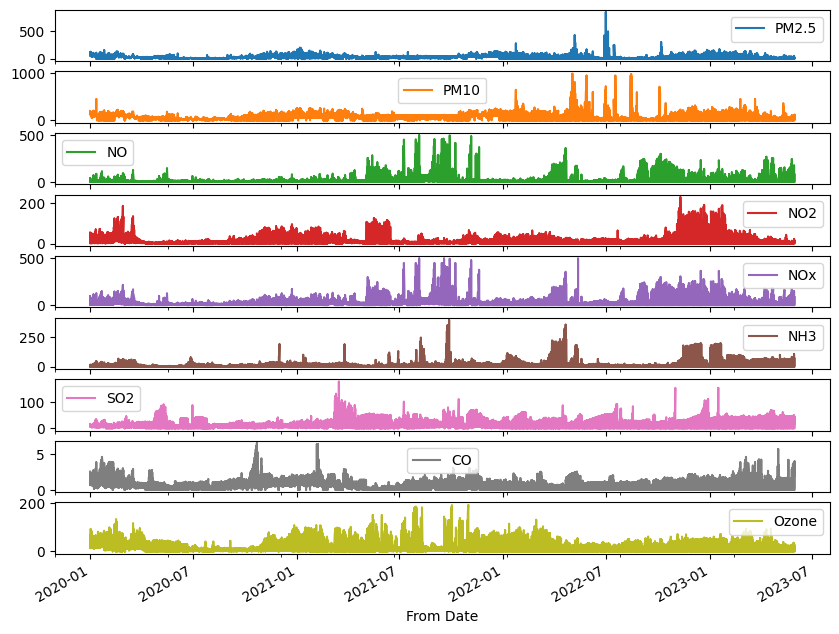

In [12]:
final_df.set_index('From Date')[['PM2.5','PM10','NO','NO2','NOx','NH3','SO2','CO','Ozone']].plot(subplots=True)

In [13]:
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

final_df["PM2.5_SubIndex"] = final_df['PM2.5'].apply(lambda x: get_PM25_subindex(x))

In [14]:
## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

final_df["PM10_SubIndex"] = final_df["PM10"].apply(lambda x: get_PM10_subindex(x))

In [15]:
## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

final_df["SO2_SubIndex"] = final_df["SO2"].apply(lambda x: get_SO2_subindex(x))

In [16]:
## NOx Sub-Index calculation
def get_NOx_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

final_df["NOx_SubIndex"] = final_df["NOx"].apply(lambda x: get_NOx_subindex(x))

In [17]:
## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

final_df["CO_SubIndex"] = final_df["CO"].apply(lambda x: get_CO_subindex(x))

In [18]:
## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

final_df["Ozone_SubIndex"] = final_df["Ozone"].apply(lambda x: get_O3_subindex(x))

In [19]:
## NH3 Sub-Index calculation
def get_NH3_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

final_df["NH3_SubIndex"] = final_df['NH3'].apply(lambda x: get_NH3_subindex(x))

In [20]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

final_df["Checks"] = (final_df["PM2.5_SubIndex"] > 0).astype(int) + \
                (final_df["PM10_SubIndex"] > 0).astype(int) + \
                (final_df["SO2_SubIndex"] > 0).astype(int) + \
                (final_df["NOx_SubIndex"] > 0).astype(int) + \
                (final_df["CO_SubIndex"] > 0).astype(int) + \
                (final_df["NH3_SubIndex"] > 0).astype(int) + \
                (final_df["Ozone_SubIndex"] > 0).astype(int)

final_df["AQI_calculated"] = round(final_df[["PM2.5_SubIndex", "PM10_SubIndex", "SO2_SubIndex", "NOx_SubIndex",
                                  "CO_SubIndex", "Ozone_SubIndex","NH3_SubIndex"]].max(axis = 1))

# final_df.loc[final_df["PM2.5"] + final_df["PM10"] <= 0, "AQI_calculated"] = np.NaN
# final_df.loc[final_df.Checks < 3, "AQI_calculated"] = np.NaN


final_df["AQI_bucket_calculated"] = final_df["AQI_calculated"].apply(lambda x: get_AQI_bucket(x))
# final_df[~final_df.AQI_calculated.isna()].head(10)

In [21]:
# final_df.columns.get_loc("TOT-RF")

In [22]:
# final_df.columns.get_loc("PM2.5")

In [23]:
final_df.drop(['AQI_bucket_calculated','Checks','PM2.5_SubIndex', 'PM10_SubIndex', 'SO2_SubIndex', 'NOx_SubIndex',
       'CO_SubIndex', 'Ozone_SubIndex', 'NH3_SubIndex',],axis=1,inplace=True)

<Axes: >

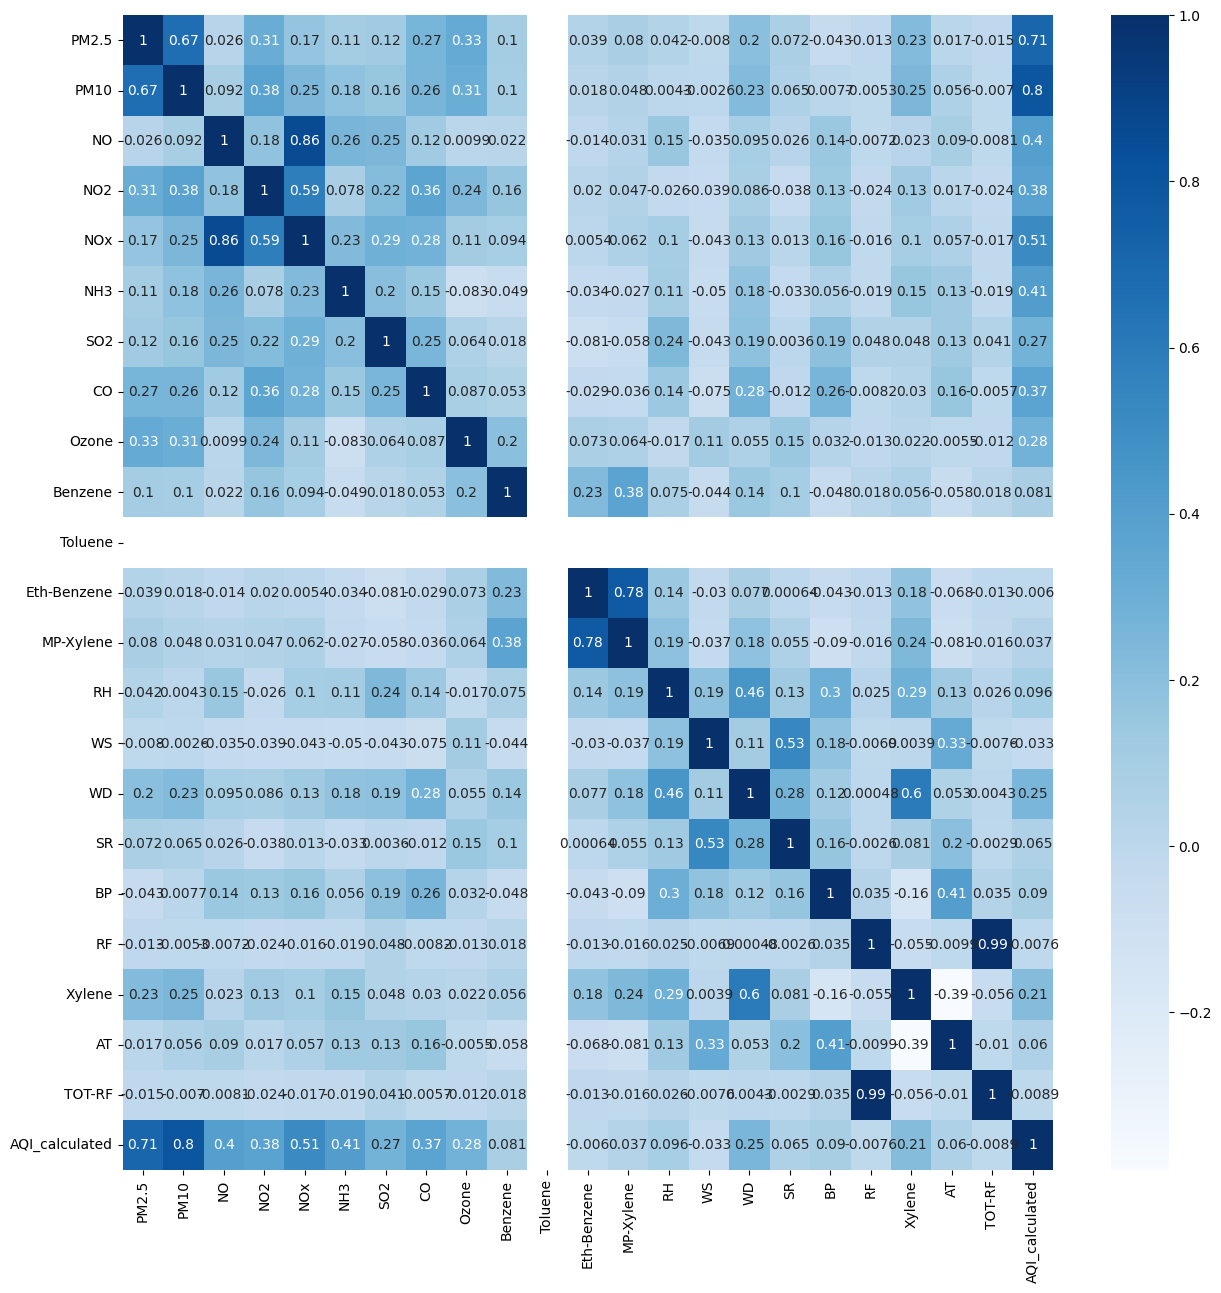

In [24]:
correlation_matrix = final_df.corr()
plt.figure(figsize = (15,15))
# Create a correlation matrix plot
sns.heatmap(correlation_matrix, annot=True, cmap='Blues')

In [25]:
final_df

From Date Station  PM2.5    PM10      NO    NO2     NOx     NH3    SO2  \
0    2020-01-01  bandra  54.66  129.15   33.13  33.83   66.98    0.00  12.36   
1    2020-01-02  bandra  60.25  117.23   17.77  28.03   45.81    0.00  14.10   
2    2020-01-03  bandra  55.67  100.72   21.19  25.70   46.89    0.00  13.20   
3    2020-01-04  bandra  31.42   49.30   16.71  23.64   40.35    0.00   4.21   
4    2020-01-05  bandra  44.59   62.40   25.56  30.41   55.98    0.00   3.90   
...         ...     ...    ...     ...     ...    ...     ...     ...    ...   
7508 2023-05-27   worli  14.80   41.44   40.67   3.22   43.31   27.12  12.48   
7509 2023-05-28   worli  13.71   34.18   48.08   4.37   52.30   37.77  13.70   
7510 2023-05-29   worli  12.57   33.00   27.21   4.92   30.65   22.84  13.68   
7511 2023-05-30   worli  12.52   34.13  116.82   4.68  120.99  105.89  15.60   
7512 2023-05-31   worli  17.99   38.41   78.98   6.43   85.40   68.11  18.25   

        CO  ...     RH    WS      WD      SR       BP   RF  Xylene     AT  \
0     2.55  ...  65.36  0.09  125.67  114.69   769.84  0.0     0.0   0.00   
1     2.38  ...  71.28  0.08  109.09  112.69   771.42  0.0     0.0   0.00   
2     2.22  ...  68.72  0.12  127.71  103.66   770.80  0.0     0.0   0.00   
3     2.03  ...  64.46  0.10  113.06  107.06   769.49  0.0     0.0   0.00   
4     2.43  ...  64.61  0.26  127.22  106.37   768.44  0.0     0.0   0.00   
...    ...  ...    ...   ...     ...     ...      ...  ...     ...    ...   
7508  1.49  ...  74.44  1.22  221.75  263.94  1010.32  0.0     0.0  30.32   
7509  1.50  ...  75.51  0.93  230.95  279.35  1009.22  0.0     0.0  30.45   
7510  1.52  ...  78.54  1.02  228.69  263.70  1008.80  0.0     0.0  30.26   
7511  1.63  ...  78.79  0.97  223.63  304.63  1008.80  0.0     0.0  30.27   
7512  1.95  ...  80.90  0.82  222.21  297.13  1009.08  0.0     0.0  30.24   

      TOT-RF  AQI_calculated  
0        0.0           119.0  
1        0.0           111.0  
2        0.0           103.0  
3        0.0           100.0  
4        0.0           105.0  
...      ...             ...  
7508     0.0            74.0  
7509     0.0            75.0  
7510     0.0            76.0  
7511     0.0           253.0  
7512     0.0           127.0  

[7513 rows x 25 columns]

In [26]:
final_df.columns

Index(['From Date', 'Station', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3',
       'SO2', 'CO', 'Ozone', 'Benzene', 'Toluene', 'Eth-Benzene', 'MP-Xylene',
       'RH', 'WS', 'WD', 'SR', 'BP', 'RF', 'Xylene', 'AT', 'TOT-RF',
       'AQI_calculated'],
      dtype='object')

### Calculate average of aqi and pollutants by each day

In [27]:
# Calculate the AQI for each date by taking the mean of pollutants and AQI based on station
average_data = final_df.groupby('From Date').mean(numeric_only=True).reset_index()
average_data

From Date       PM2.5        PM10         NO        NO2        NOx  \
0    2020-01-01   93.946667  158.266667  25.185000  37.113333  62.298333   
1    2020-01-02  102.830000  153.696667   7.301667  30.755000  38.048333   
2    2020-01-03   88.095000  137.146667  10.633333  30.720000  41.320000   
3    2020-01-04   82.038333  126.623333   7.883333  27.670000  35.508333   
4    2020-01-05   82.461667  136.378333  14.751667  32.425000  47.133333   
...         ...         ...         ...        ...        ...        ...   
1242 2023-05-27   11.866667   38.270000   9.888333   4.163333  13.951667   
1243 2023-05-28   11.655000   34.270000  10.236667   4.093333  14.283333   
1244 2023-05-29   11.900000   46.108333   8.895000   4.265000  12.890000   
1245 2023-05-30   17.256667   48.786667  54.855000   7.051667  56.521667   
1246 2023-05-31   13.616667   52.098333  23.795000   7.213333  27.785000   

            NH3        SO2        CO      Ozone  ...         RH        WS  \
0      9.065000  10.951667  1.250000  46.341667  ...  59.193333  5.471667   
1      9.871667   8.580000  1.083333  49.901667  ...  62.991667  5.225000   
2      8.805000   8.500000  1.025000  48.735000  ...  60.230000  3.206667   
3      8.966667   6.160000  0.991667  51.958333  ...  58.311667  0.896667   
4     10.610000   7.681667  1.131667  40.641667  ...  57.173333  0.870000   
...         ...        ...       ...        ...  ...        ...       ...   
1242  16.928333  14.145000  1.060000   7.055000  ...  51.265000  6.888333   
1243  18.623333  11.631667  1.100000   3.308333  ...  38.005000  0.523333   
1244  15.638333  14.968333  1.186667   9.376667  ...  52.105000  6.263333   
1245  40.440000  15.790000  1.258333   9.070000  ...  54.390000  6.325000   
1246  26.180000  16.265000  1.328333   7.858333  ...  55.723333  6.251667   

              WD          SR          BP   RF     Xylene         AT  TOT-RF  \
0     158.550000  204.648333  128.306667  0.0  17.606667   0.000000     0.0   
1     157.755000  191.753333  128.570000  0.0  18.563333   0.000000     0.0   
2     156.036667  199.915000  128.466667  0.0  18.231667   0.000000     0.0   
3     162.840000  207.628333  128.248333  0.0  17.521667   0.000000     0.0   
4     155.650000  210.105000  128.073333  0.0  19.158333   0.000000     0.0   
...          ...         ...         ...  ...        ...        ...     ...   
1242  141.565000  304.718333  662.938333  0.0   4.385000  19.743333     0.0   
1243  117.413333   99.475000  494.965000  0.0   4.328333  14.960000     0.0   
1244  131.661667  291.291667  664.411667  0.0   4.105000  20.046667     0.0   
1245  131.673333  290.250000  662.653333  0.0   4.058333  19.593333     0.0   
1246  145.875000  302.013333  667.358333  0.0   4.181667  19.656667     0.0   

      AQI_calculated  
0         219.166667  
1         242.500000  
2         196.666667  
3         189.333333  
4         184.333333  
...              ...  
1242       61.666667  
1243       62.166667  
1244       67.500000  
1245      109.166667  
1246       80.666667  

[1247 rows x 24 columns]

In [28]:
average_data.columns

Index(['From Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'SO2', 'CO',
       'Ozone', 'Benzene', 'Toluene', 'Eth-Benzene', 'MP-Xylene', 'RH', 'WS',
       'WD', 'SR', 'BP', 'RF', 'Xylene', 'AT', 'TOT-RF', 'AQI_calculated'],
      dtype='object')

In [29]:
average_data[average_data['From Date']== '2020-01-01']

From Date      PM2.5        PM10      NO        NO2        NOx    NH3  \
0 2020-01-01  93.946667  158.266667  25.185  37.113333  62.298333  9.065   

         SO2    CO      Ozone  ...         RH        WS      WD          SR  \
0  10.951667  1.25  46.341667  ...  59.193333  5.471667  158.55  204.648333   

           BP   RF     Xylene   AT  TOT-RF  AQI_calculated  
0  128.306667  0.0  17.606667  0.0     0.0      219.166667  

[1 rows x 24 columns]

In [30]:
final_df = average_data

In [31]:
final_df[['From Date', "AQI_calculated"]].tail()

From Date  AQI_calculated
1242 2023-05-27       61.666667
1243 2023-05-28       62.166667
1244 2023-05-29       67.500000
1245 2023-05-30      109.166667
1246 2023-05-31       80.666667

In [32]:
ddf = final_df[final_df['From Date'] > '2022-12-01']
ddf[['From Date','AQI_calculated']]

From Date  AQI_calculated
1066 2022-12-02      217.500000
1067 2022-12-03      204.333333
1068 2022-12-04      189.166667
1069 2022-12-05      235.666667
1070 2022-12-06      253.333333
...         ...             ...
1242 2023-05-27       61.666667
1243 2023-05-28       62.166667
1244 2023-05-29       67.500000
1245 2023-05-30      109.166667
1246 2023-05-31       80.666667

[181 rows x 2 columns]

### Feature Engineering

In [33]:
final_df[final_df.AQI_calculated.isna()].head()

Empty DataFrame
Columns: [From Date, PM2.5, PM10, NO, NO2, NOx, NH3, SO2, CO, Ozone, Benzene, Toluene, Eth-Benzene, MP-Xylene, RH, WS, WD, SR, BP, RF, Xylene, AT, TOT-RF, AQI_calculated]
Index: []

[0 rows x 24 columns]

In [34]:
final_df['AQI_calculated'] = final_df['AQI_calculated'].fillna(0)

In [35]:
final_df = final_df[final_df.AQI_calculated != 0]

In [36]:
final_df.shape

(1247, 24)

In [37]:
final_df

From Date       PM2.5        PM10         NO        NO2        NOx  \
0    2020-01-01   93.946667  158.266667  25.185000  37.113333  62.298333   
1    2020-01-02  102.830000  153.696667   7.301667  30.755000  38.048333   
2    2020-01-03   88.095000  137.146667  10.633333  30.720000  41.320000   
3    2020-01-04   82.038333  126.623333   7.883333  27.670000  35.508333   
4    2020-01-05   82.461667  136.378333  14.751667  32.425000  47.133333   
...         ...         ...         ...        ...        ...        ...   
1242 2023-05-27   11.866667   38.270000   9.888333   4.163333  13.951667   
1243 2023-05-28   11.655000   34.270000  10.236667   4.093333  14.283333   
1244 2023-05-29   11.900000   46.108333   8.895000   4.265000  12.890000   
1245 2023-05-30   17.256667   48.786667  54.855000   7.051667  56.521667   
1246 2023-05-31   13.616667   52.098333  23.795000   7.213333  27.785000   

            NH3        SO2        CO      Ozone  ...         RH        WS  \
0      9.065000  10.951667  1.250000  46.341667  ...  59.193333  5.471667   
1      9.871667   8.580000  1.083333  49.901667  ...  62.991667  5.225000   
2      8.805000   8.500000  1.025000  48.735000  ...  60.230000  3.206667   
3      8.966667   6.160000  0.991667  51.958333  ...  58.311667  0.896667   
4     10.610000   7.681667  1.131667  40.641667  ...  57.173333  0.870000   
...         ...        ...       ...        ...  ...        ...       ...   
1242  16.928333  14.145000  1.060000   7.055000  ...  51.265000  6.888333   
1243  18.623333  11.631667  1.100000   3.308333  ...  38.005000  0.523333   
1244  15.638333  14.968333  1.186667   9.376667  ...  52.105000  6.263333   
1245  40.440000  15.790000  1.258333   9.070000  ...  54.390000  6.325000   
1246  26.180000  16.265000  1.328333   7.858333  ...  55.723333  6.251667   

              WD          SR          BP   RF     Xylene         AT  TOT-RF  \
0     158.550000  204.648333  128.306667  0.0  17.606667   0.000000     0.0   
1     157.755000  191.753333  128.570000  0.0  18.563333   0.000000     0.0   
2     156.036667  199.915000  128.466667  0.0  18.231667   0.000000     0.0   
3     162.840000  207.628333  128.248333  0.0  17.521667   0.000000     0.0   
4     155.650000  210.105000  128.073333  0.0  19.158333   0.000000     0.0   
...          ...         ...         ...  ...        ...        ...     ...   
1242  141.565000  304.718333  662.938333  0.0   4.385000  19.743333     0.0   
1243  117.413333   99.475000  494.965000  0.0   4.328333  14.960000     0.0   
1244  131.661667  291.291667  664.411667  0.0   4.105000  20.046667     0.0   
1245  131.673333  290.250000  662.653333  0.0   4.058333  19.593333     0.0   
1246  145.875000  302.013333  667.358333  0.0   4.181667  19.656667     0.0   

      AQI_calculated  
0         219.166667  
1         242.500000  
2         196.666667  
3         189.333333  
4         184.333333  
...              ...  
1242       61.666667  
1243       62.166667  
1244       67.500000  
1245      109.166667  
1246       80.666667  

[1247 rows x 24 columns]

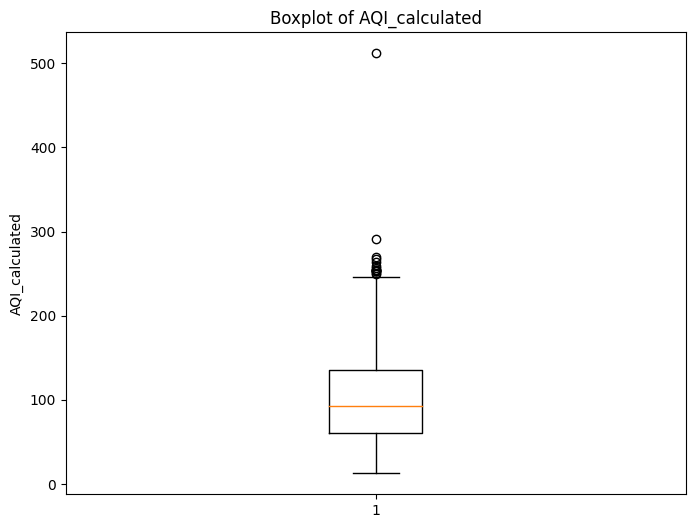

In [38]:
plt.figure(figsize=(8, 6))
plt.boxplot(final_df['AQI_calculated'])
plt.title('Boxplot of AQI_calculated')
plt.ylabel('AQI_calculated')
plt.show()

In [39]:
print(pywt.wavelist(kind='discrete'))

['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'haar', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17', 'sym18', 'sym19', 'sym20']


### STL Decomposition

In [40]:
# from statsmodels.tsa.stattools import acf
# # Assuming your dataset is stored in a pandas DataFrame called 'df'
# data = final_df['AQI_calculated']  # Select the column containing AQI values

# # Calculate the autocorrelation function
# acf_values = acf(data, fft=True, nlags=365)  # Set 'nlags' to cover a year's worth of data

# # Find the lag with the highest ACF value
# period = acf_values.argmax() + 1  # Add 1 to account for zero-based indexing
# print("Estimated period:", period)

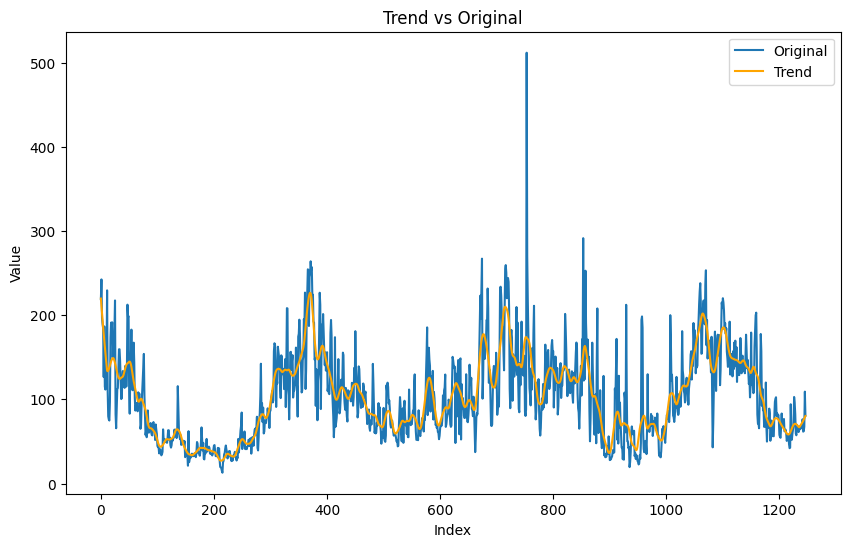

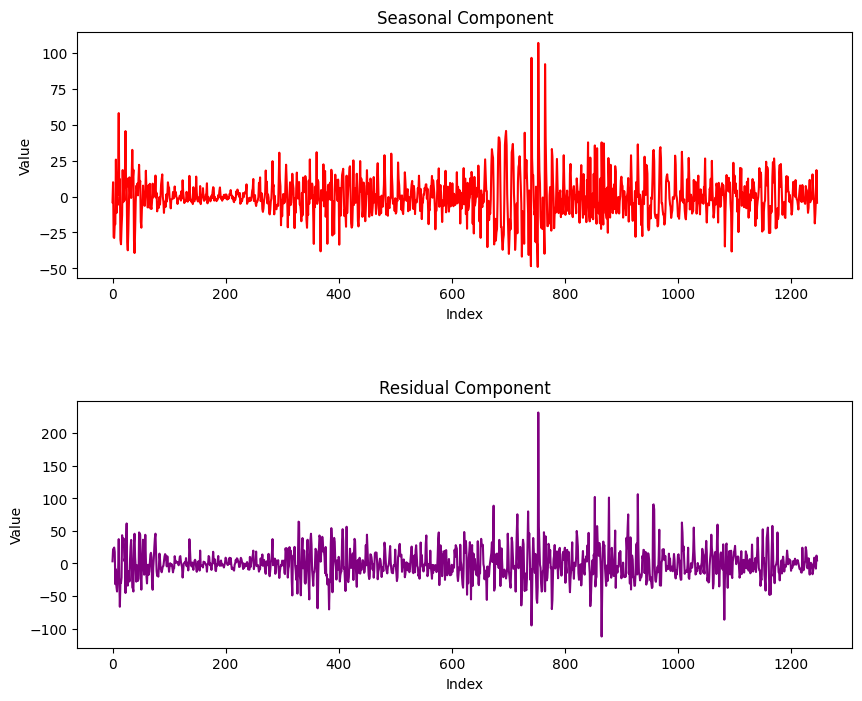

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# Perform STL decomposition on the 'AQI_calculated' column
def perform_stl_decomposition(data, period):
    stl = STL(data, period=period)
    result = stl.fit()
    return result

# Define the period for seasonal decomposition
period = 12  # Manually specify the period based on the seasonal pattern in your data

# Get the 'AQI_calculated' column from the DataFrame
data = final_df['AQI_calculated'].values

# Perform STL decomposition
result = perform_stl_decomposition(data, period)

# Extract the components from the decomposition result
trend = result.trend
seasonal = result.seasonal
residual = result.resid

final_df['Trend'] = trend
final_df['Seasonal'] = seasonal
final_df['Residual'] = residual

data1 = final_df['PM2.5'].values

# Perform STL decomposition
pm2result = perform_stl_decomposition(data1, period)

# Extract the components from the decomposition result
pm2trend = pm2result.trend
pm2seasonal = pm2result.seasonal
pm2residual = pm2result.resid

final_df['PM2.5_Trend'] = pm2trend
final_df['PM2.5_Seasonal'] = pm2seasonal
final_df['PM2.5_Residual'] = pm2residual


data2 = final_df['PM10'].values

# Perform STL decomposition
pm10result = perform_stl_decomposition(data2, period)

# Extract the components from the decomposition result
pm10trend = pm10result.trend
pm10seasonal = pm10result.seasonal
pm10residual = pm10result.resid

final_df['PM10_Trend'] = pm10trend
final_df['PM10_Seasonal'] = pm10seasonal
final_df['PM10_Residual'] = pm10residual




# Plot the trend and original time series on one plot
plt.figure(figsize=(10, 6))
plt.plot(final_df.index, data, label='Original')
plt.plot(final_df.index, trend, label='Trend', color='orange')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Trend vs Original')
plt.legend()

# Create subplots for the seasonal and residual components
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.5)

# Plot the seasonal component
axs[0].plot(final_df.index, seasonal, color='red')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Value')
axs[0].set_title('Seasonal Component')

# Plot the residual component
axs[1].plot(final_df.index, residual, color='purple')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Value')
axs[1].set_title('Residual Component')

plt.show()


In [42]:
final_df.head()

From Date       PM2.5        PM10         NO        NO2        NOx  \
0 2020-01-01   93.946667  158.266667  25.185000  37.113333  62.298333   
1 2020-01-02  102.830000  153.696667   7.301667  30.755000  38.048333   
2 2020-01-03   88.095000  137.146667  10.633333  30.720000  41.320000   
3 2020-01-04   82.038333  126.623333   7.883333  27.670000  35.508333   
4 2020-01-05   82.461667  136.378333  14.751667  32.425000  47.133333   

         NH3        SO2        CO      Ozone  ...  AQI_calculated       Trend  \
0   9.065000  10.951667  1.250000  46.341667  ...      219.166667  219.770129   
1   9.871667   8.580000  1.083333  49.901667  ...      242.500000  210.804098   
2   8.805000   8.500000  1.025000  48.735000  ...      196.666667  202.085462   
3   8.966667   6.160000  0.991667  51.958333  ...      189.333333  193.638831   
4  10.610000   7.681667  1.131667  40.641667  ...      184.333333  185.472679   

    Seasonal   Residual  PM2.5_Trend  PM2.5_Seasonal  PM2.5_Residual  \
0  -3.947728   3.344265   100.125527       -2.603838       -3.575023   
1   9.938394  21.757508    95.855682        0.450605        6.523712   
2 -28.239329  22.820533    91.672709      -15.705379       12.127670   
3 -28.823139  24.517641    87.590955      -16.101926       10.549305   
4 -18.769107  17.629761    83.617734      -10.746583        9.590517   

   PM10_Trend  PM10_Seasonal  PM10_Residual  
0  169.264900     -14.589666       3.591433  
1  163.502305     -16.451781       6.646143  
2  157.840864     -32.710859      12.016662  
3  152.289251     -34.923164       9.257246  
4  146.848504     -17.424242       6.954071  

[5 rows x 33 columns]

In [43]:
true_forecast1 = final_df[final_df['From Date'] >= '2023-05-01']
final_df = final_df[final_df['From Date'] < '2023-05-01']
true_forecast1

From Date      PM2.5        PM10         NO        NO2        NOx  \
1216 2023-05-01   8.983333   33.045000   8.591667   7.758333  14.690000   
1217 2023-05-02   9.143333   24.573333   9.625000   6.166667  14.040000   
1218 2023-05-03   9.675000   25.560000  14.483333   4.366667  14.838333   
1219 2023-05-04  11.398333   30.735000  31.041667   4.381667  25.511667   
1220 2023-05-05  12.020000   41.635000  45.018333   6.278333  39.821667   
1221 2023-05-06  17.013333   41.606667  36.621667   5.043333  30.391667   
1222 2023-05-07  11.748333   30.931667  29.910000   4.308333  22.800000   
1223 2023-05-08  14.350000   43.336667  26.238333   4.561667  22.506667   
1224 2023-05-09  13.198333   53.400000   9.643333   5.863333  14.310000   
1225 2023-05-10  16.560000   65.871667  10.241667   5.370000  15.145000   
1226 2023-05-11  22.456667  107.916667  15.273333   5.486667  16.633333   
1227 2023-05-12  23.978333  101.656667  30.156667   7.806667  30.445000   
1228 2023-05-13  20.848333   75.493333  30.861667   4.605000  36.080000   
1229 2023-05-14   9.351667   48.073333  18.415000   3.895000  19.156667   
1230 2023-05-15  17.886667   49.935000  18.656667   8.393333  23.688333   
1231 2023-05-16  18.541667   54.310000  17.770000  10.801667  23.706667   
1232 2023-05-17  12.430000   37.678333  28.561667   6.285000  29.115000   
1233 2023-05-18  10.273333   36.515000  26.160000   5.180000  26.530000   
1234 2023-05-19   8.220000   37.013333  25.726667   5.070000  25.523333   
1235 2023-05-20  10.900000   31.048333  29.175000   4.701667  27.433333   
1236 2023-05-21  14.946667   42.065000  31.325000   4.466667  28.811667   
1237 2023-05-22   9.968333   39.338333  33.315000   4.181667  30.023333   
1238 2023-05-23  11.485000   42.463333  39.830000   3.560000  35.288333   
1239 2023-05-24  13.838333   38.911667  38.041667   3.396667  32.523333   
1240 2023-05-25   9.020000   27.606667  40.421667   3.351667  34.175000   
1241 2023-05-26  15.903333   54.185000  52.623333   5.383333  45.040000   
1242 2023-05-27  11.866667   38.270000   9.888333   4.163333  13.951667   
1243 2023-05-28  11.655000   34.270000  10.236667   4.093333  14.283333   
1244 2023-05-29  11.900000   46.108333   8.895000   4.265000  12.890000   
1245 2023-05-30  17.256667   48.786667  54.855000   7.051667  56.521667   
1246 2023-05-31  13.616667   52.098333  23.795000   7.213333  27.785000   

            NH3        SO2        CO      Ozone  ...  AQI_calculated  \
1216  16.053333  13.165000  0.843333   9.951667  ...       58.166667   
1217   5.801667   6.573333  1.268333   7.900000  ...       46.833333   
1218   7.338333   6.458333  0.876667   7.093333  ...       42.000000   
1219  10.396667   6.705000  0.326667   7.028333  ...       42.666667   
1220  35.461667  14.393333  0.396667   8.708333  ...       94.166667   
1221  23.651667  19.713333  0.620000   6.766667  ...       68.000000   
1222  19.298333  12.255000  0.295000   5.530000  ...       52.000000   
1223  18.346667  14.673333  0.575000   6.108333  ...       59.333333   
1224  15.240000  14.810000  0.616667   7.115000  ...       64.166667   
1225  14.595000  16.291667  0.670000   7.728333  ...       68.666667   
1226  16.950000  14.743333  0.711667  10.065000  ...      102.833333   
1227  22.061667  15.036667  0.615000  10.433333  ...       95.666667   
1228  25.848333  13.431667  0.645000   8.471667  ...       82.500000   
1229  18.613333  12.681667  0.626667   8.606667  ...       59.333333   
1230  19.635000  15.233333  0.616667  10.955000  ...       57.333333   
1231  16.118333  13.958333  0.663333   9.060000  ...       69.666667   
1232  20.185000  13.168333  0.645000   6.703333  ...       66.500000   
1233  19.683333  13.381667  0.618333   6.898333  ...       62.500000   
1234  20.448333  13.811667  0.830000   7.761667  ...       61.166667   
1235  21.653333  17.166667  1.223333   7.375000  ...       67.833333   
1236  21.516667  13.120000  0.508333   7.250000  ...       65.166667   
1237  21.703333  12.8

In [44]:
# df_input = final_df[['From Date','PM2.5','PM10','NO2','SO2', 'NOx','CO', 'NH3', 'Ozone','AQI_calculated','Trend']]
# df_input = final_df[['From Date','AQI_calculated' ,'PM2.5', 'PM10']]
trend_data = final_df[['From Date','PM2.5_Trend','PM10_Trend','Trend']]
seasonal_data = final_df[['From Date','PM2.5_Seasonal','PM10_Seasonal','Seasonal' ]]
residual_data = final_df[['From Date','PM2.5_Residual','PM10_Residual','Residual']]
trend_data.set_index('From Date', inplace = True)
seasonal_data.set_index('From Date', inplace = True)
residual_data.set_index('From Date', inplace = True)
# df_input = final_df[['PM2.5','PM10','AQI_calculated']]

In [45]:
trend_data.describe()

PM2.5_Trend   PM10_Trend        Trend
count  1216.000000  1216.000000  1216.000000
mean     36.497897    79.745603   103.661762
std      21.228966    36.167703    43.932915
min       5.230205    14.207651    27.175376
25%      18.954919    50.181398    68.991209
50%      33.822760    81.652077   102.006572
75%      53.162433   108.159691   135.856592
max     100.125527   174.435824   226.548201

In [46]:
# df_input.query('PM10 > 500')

In [47]:
trend_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1216 entries, 2020-01-01 to 2023-04-30
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PM2.5_Trend  1216 non-null   float64
 1   PM10_Trend   1216 non-null   float64
 2   Trend        1216 non-null   float64
dtypes: float64(3)
memory usage: 38.0 KB


In [48]:
len(final_df)

1216

In [49]:
final_df.tail()

From Date      PM2.5       PM10         NO       NO2        NOx  \
1211 2023-04-26  19.888333  59.226667  13.706667  7.431667  15.573333   
1212 2023-04-27  16.260000  51.305000  17.386667  7.976667  17.883333   
1213 2023-04-28  12.031667  37.636667  14.866667  7.645000  16.546667   
1214 2023-04-29  12.581667  35.943333   7.536667  7.368333  14.390000   
1215 2023-04-30   9.091667  34.196667  11.085000  6.176667  14.896667   

            NH3        SO2        CO      Ozone  ...  AQI_calculated  \
1211  16.815000  12.790000  0.455000   8.681667  ...       64.000000   
1212  17.745000  13.086667  0.456667  12.728333  ...       59.666667   
1213  17.918333  13.600000  0.606667  11.018333  ...       50.666667   
1214  15.281667  13.158333  0.730000  11.425000  ...       53.833333   
1215  15.678333  13.271667  0.576667  12.476667  ...       54.166667   

          Trend  Seasonal  Residual  PM2.5_Trend  PM2.5_Seasonal  \
1211  61.373648 -2.573020  5.199372    14.721583       -1.243064   
1212  60.338300 -5.503315  4.831681    14.191181       -1.816547   
1213  59.494338 -9.015584  0.187913    13.822022       -4.065124   
1214  58.845542 -0.619943 -4.392265    13.578726       -0.906466   
1215  58.414155  4.031722 -8.279211    13.377154        2.438097   

      PM2.5_Residual  PM10_Trend  PM10_Seasonal  PM10_Residual  
1211        6.409815   44.256946      -4.951746      19.921467  
1212        3.885366   42.608305      -2.309499      11.006193  
1213        2.274769   41.320361      -5.577720       1.894025  
1214       -0.090593   40.366265       5.831679     -10.254611  
1215       -6.723584   39.691484      12.312518     -17.807335  

[5 rows x 33 columns]

In [50]:
# trueForecast = final_df[1698:]
# trueForecast

In [51]:
trend_data.head(10)

PM2.5_Trend  PM10_Trend       Trend
From Date                                      
2020-01-01   100.125527  169.264900  219.770129
2020-01-02    95.855682  163.502305  210.804098
2020-01-03    91.672709  157.840864  202.085462
2020-01-04    87.590955  152.289251  193.638831
2020-01-05    83.617734  146.848504  185.472679
2020-01-06    79.751662  141.511222  177.575105
2020-01-07    75.982344  136.262513  169.915101
2020-01-08    72.294730  131.085612  162.454778
2020-01-09    68.664428  125.959276  155.138131
2020-01-10    65.054181  120.863553  147.888792

In [52]:
# test = df_input.iloc[1512:1698]
# train = df_input.iloc[:1512]
# test = df_input.iloc[972:]
# train = df_input.iloc[:972]

# Trend Train Test
trendtest = trend_data.iloc[972:]
trendtrain = trend_data.iloc[:972]

# Seasonal Train Test
seasonaltest = seasonal_data.iloc[972:]
seasonaltrain = seasonal_data.iloc[:972]

# Residual Train Test
residualtest = residual_data.iloc[972:]
residualtrain = residual_data.iloc[:972]


In [53]:
seasonaltrain

PM2.5_Seasonal  PM10_Seasonal   Seasonal
From Date                                           
2020-01-01       -2.603838     -14.589666  -3.947728
2020-01-02        0.450605     -16.451781   9.938394
2020-01-03      -15.705379     -32.710859 -28.239329
2020-01-04      -16.101926     -34.923164 -28.823139
2020-01-05      -10.746583     -17.424242 -18.769107
...                    ...            ...        ...
2022-08-25       -1.417972      15.855156  12.709619
2022-08-26        0.536078      30.806545  32.340119
2022-08-27        0.739166      29.945075  34.319494
2022-08-28       -0.076185      19.977625  26.452544
2022-08-29        0.229376      -7.429110  -4.599623

[972 rows x 3 columns]

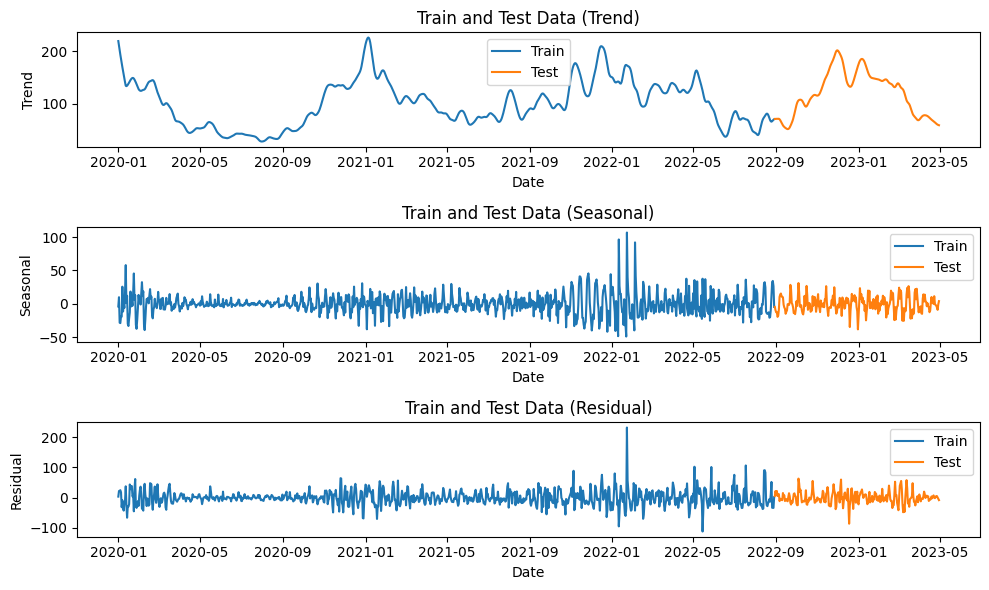

In [54]:
# Create subplots
original_rcParams = plt.rcParams.copy()
fig, axs = plt.subplots(3, 1,figsize=(10, 6))

# Plot for Trend

axs[0].plot(trendtrain.index, trendtrain.Trend, label='Train')
axs[0].plot(trendtest.index, trendtest.Trend, label='Test')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Trend')
axs[0].set_title('Train and Test Data (Trend)')
axs[0].legend()

# # Plot for Seasonal
axs[1].plot(seasonaltrain.index, seasonaltrain.Seasonal, label='Train')
axs[1].plot(seasonaltest.index, seasonaltest.Seasonal, label='Test')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Seasonal')
axs[1].set_title('Train and Test Data (Seasonal)')
axs[1].legend()

# # Plot for Residual
axs[2].plot(residualtrain.index, residualtrain.Residual, label='Train')
axs[2].plot(residualtest.index, residualtest.Residual, label='Test')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Residual')
axs[2].set_title('Train and Test Data (Residual)')
axs[2].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


In [55]:
plt.rcParams.update(original_rcParams)

In [56]:
trendtest

PM2.5_Trend  PM10_Trend      Trend
From Date                                     
2022-08-30    13.792296   41.323460  70.424266
2022-08-31    14.079965   38.403335  70.638175
2022-09-01    14.335038   35.509846  70.676703
2022-09-02    14.587655   32.855580  70.709838
2022-09-03    14.822128   30.650370  70.824614
...                 ...         ...        ...
2023-04-26    14.721583   44.256946  61.373648
2023-04-27    14.191181   42.608305  60.338300
2023-04-28    13.822022   41.320361  59.494338
2023-04-29    13.578726   40.366265  58.845542
2023-04-30    13.377154   39.691484  58.414155

[244 rows x 3 columns]

### Trend

In [1063]:
# Scaling and timeseries generator for trend
scaler = MinMaxScaler()
scaler.fit(trendtrain)

trend_scaled_train = scaler.transform(trendtrain)
trend_scaled_test = scaler.transform(trendtest)

win_length = 31
batch_size = 12
num_features = 3
trend_train_generator = TimeseriesGenerator(trend_scaled_train,trend_scaled_train, length = win_length,sampling_rate=1,batch_size=batch_size)
trend_test_generator = TimeseriesGenerator(trend_scaled_test,trend_scaled_test, length = win_length,sampling_rate=1,batch_size=batch_size)

In [1064]:
# Deep learning model for Trend
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf
trendmodel = tf.keras.Sequential()
trendmodel.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(win_length, num_features)))
trendmodel.add(LSTM(32))
trendmodel.add(Dense(trend_scaled_train.shape[1]))
trendmodel.compile(loss='mse', optimizer='adam')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
#
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
#
validation_generator = TimeseriesGenerator(trend_scaled_test, trend_scaled_test, length=win_length, batch_size=batch_size)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

trendmodel.compile(loss=tf.losses.MeanSquaredError(), optimizer=optimizer)

history = trendmodel.fit(trend_train_generator, epochs=75, validation_data=validation_generator, shuffle=False, callbacks=[early_stopping])


Epoch 1/75
79/79 [==============================] - 5s 27ms/step - loss: 0.0363 - val_loss: 0.0105
Epoch 2/75
79/79 [==============================] - 2s 28ms/step - loss: 0.0117 - val_loss: 0.0131
Epoch 3/75
79/79 [==============================] - 2s 23ms/step - loss: 0.0066 - val_loss: 0.0096
Epoch 4/75
79/79 [==============================] - 2s 20ms/step - loss: 0.0048 - val_loss: 0.0088
Epoch 5/75
79/79 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0086
Epoch 6/75
79/79 [==============================] - 2s 21ms/step - loss: 0.0037 - val_loss: 0.0082
Epoch 7/75
79/79 [==============================] - 2s 20ms/step - loss: 0.0034 - val_loss: 0.0078
Epoch 8/75
79/79 [==============================] - 2s 28ms/step - loss: 0.0032 - val_loss: 0.0075
Epoch 9/75
79/79 [==============================] - 2s 21ms/step - loss: 0.0030 - val_loss: 0.0064
Epoch 10/75
79/79 [==============================] - 2s 20ms/step - loss: 0.0028 - val_loss: 0.0061
Epoch 11/

In [1065]:
trendmodel.evaluate(trend_test_generator,verbose=0)

0.0034566987305879593

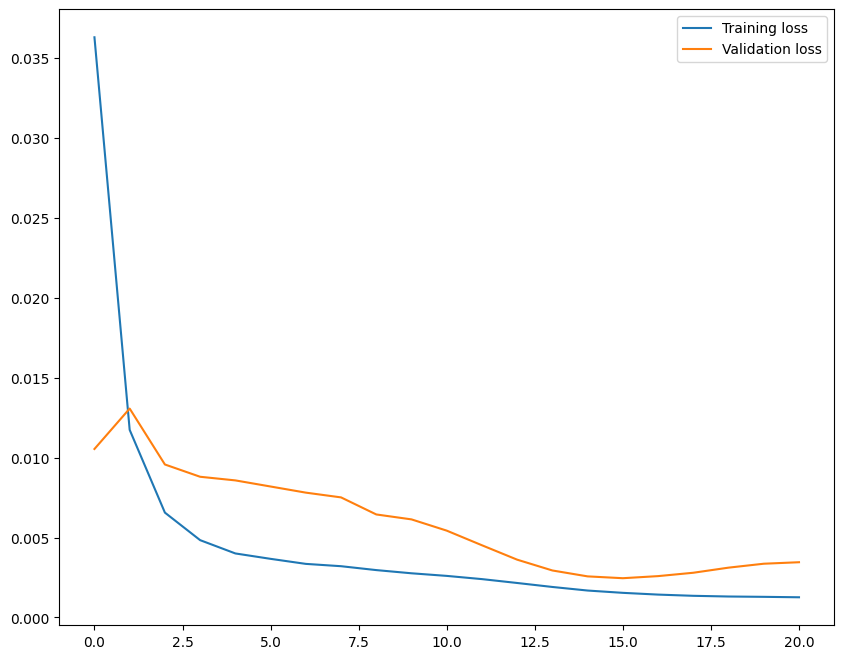

In [1066]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

####  Train Prediction

In [1098]:
# LOAD MODEL
trendmodel =  tf.keras.models.load_model('/content/TrendRMSE3.29,MAPE0.02,R20.99.h5')

In [1099]:
predictions=trendmodel.predict(trend_train_generator)

79/79 [==============================] - 1s 5ms/step


In [1100]:
df_pred = pd.DataFrame(predictions)

In [1101]:
rev_trans=scaler.inverse_transform(df_pred)

In [1102]:
df_final=trendtrain[31:972]
df_final

PM2.5_Trend  PM10_Trend       Trend
From Date                                      
2020-02-01    49.376836   99.100945  125.935322
2020-02-02    49.080285   99.151276  124.823761
2020-02-03    49.191796   99.492640  124.329069
2020-02-04    49.700691  100.053726  124.435516
2020-02-05    50.532540  100.902854  125.099968
...                 ...         ...         ...
2022-08-25    11.149522   50.991083   65.277156
2022-08-26    11.842019   49.305180   66.073707
2022-08-27    12.477714   47.975471   67.554605
2022-08-28    13.016147   46.299466   68.935827
2022-08-29    13.447311   44.038833   69.894302

[941 rows x 3 columns]

In [1103]:
len(rev_trans[:,2])

941

In [1104]:
df_final

PM2.5_Trend  PM10_Trend       Trend
From Date                                      
2020-02-01    49.376836   99.100945  125.935322
2020-02-02    49.080285   99.151276  124.823761
2020-02-03    49.191796   99.492640  124.329069
2020-02-04    49.700691  100.053726  124.435516
2020-02-05    50.532540  100.902854  125.099968
...                 ...         ...         ...
2022-08-25    11.149522   50.991083   65.277156
2022-08-26    11.842019   49.305180   66.073707
2022-08-27    12.477714   47.975471   67.554605
2022-08-28    13.016147   46.299466   68.935827
2022-08-29    13.447311   44.038833   69.894302

[941 rows x 3 columns]

In [1105]:
df_final['Aqi_Trend_Pred']=rev_trans[:,2]

<Axes: xlabel='From Date'>

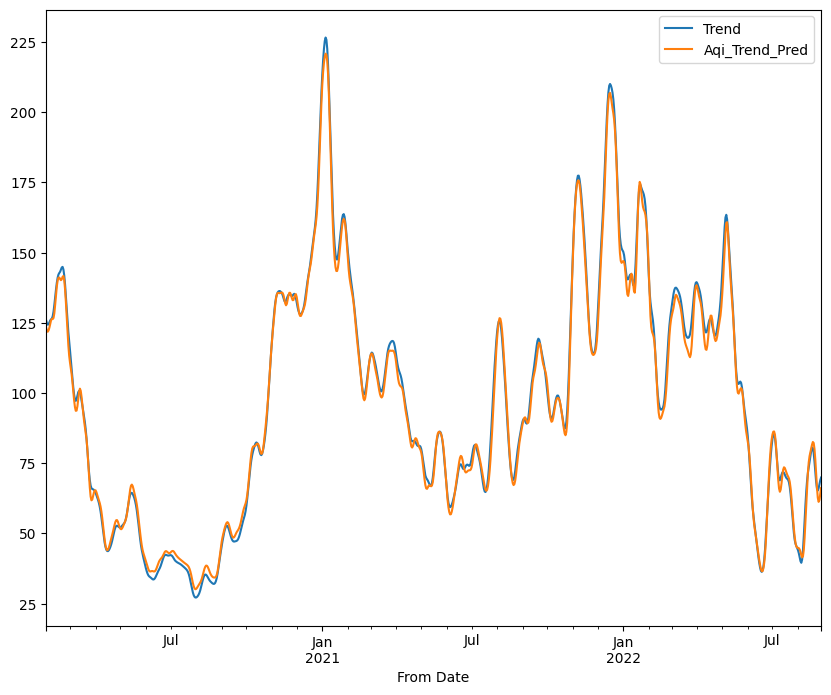

In [1106]:
df_final[['Trend','Aqi_Trend_Pred']].plot()

In [1107]:
trueAqi = df_final['Trend']

forcastAQI = df_final['Aqi_Trend_Pred']

train_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',train_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

RMSE =  2.655490700216732
Mean =  97.85004520584347
MAPE =  0.026311409251021635
R2 Score =  0.9958814205929655


#### Test Prediction

In [1108]:
predictions=trendmodel.predict(trend_test_generator)

18/18 [==============================] - 0s 7ms/step


In [1109]:
df_pred = pd.DataFrame(predictions)

In [1110]:
rev_trans=scaler.inverse_transform(df_pred)
len(rev_trans)

213

In [1111]:
trend_pred=trend_data[predictions.shape[0]*-1:]
trend_pred

PM2.5_Trend  PM10_Trend       Trend
From Date                                      
2022-09-30    18.713086   41.652687   91.827020
2022-10-01    20.474911   44.557136   97.037472
2022-10-02    22.156701   46.737050  101.232835
2022-10-03    23.563752   48.231358  104.175279
2022-10-04    24.587245   49.289925  105.940637
...                 ...         ...         ...
2023-04-26    14.721583   44.256946   61.373648
2023-04-27    14.191181   42.608305   60.338300
2023-04-28    13.822022   41.320361   59.494338
2023-04-29    13.578726   40.366265   58.845542
2023-04-30    13.377154   39.691484   58.414155

[213 rows x 3 columns]

In [1112]:
trend_pred['Aqi_Trend_Pred']=rev_trans[:,2]
trend_pred['PM10_Trend_Pred']=rev_trans[:,1]
trend_pred['PM2.5_Trend_Pred']=rev_trans[:,0]

In [1113]:
trend_pred

PM2.5_Trend  PM10_Trend       Trend  Aqi_Trend_Pred  \
From Date                                                         
2022-09-30    18.713086   41.652687   91.827020       89.270271   
2022-10-01    20.474911   44.557136   97.037472       95.821518   
2022-10-02    22.156701   46.737050  101.232835      101.657890   
2022-10-03    23.563752   48.231358  104.175279      106.098038   
2022-10-04    24.587245   49.289925  105.940637      108.723717   
...                 ...         ...         ...             ...   
2023-04-26    14.721583   44.256946   61.373648       61.467911   
2023-04-27    14.191181   42.608305   60.338300       60.308678   
2023-04-28    13.822022   41.320361   59.494338       59.496895   
2023-04-29    13.578726   40.366265   58.845542       59.053013   
2023-04-30    13.377154   39.691484   58.414155       58.885315   

            PM10_Trend_Pred  PM2.5_Trend_Pred  
From Date                                      
2022-09-30        40.482296         18.019321  
2022-10-01        44.379108         19.176907  
2022-10-02        47.559105         20.376711  
2022-10-03        49.681652         21.487473  
2022-10-04        50.673000         22.377094  
...                     ...               ...  
2023-04-26        45.244957         13.316392  
2023-04-27        42.973454         12.731305  
2023-04-28        41.128056         12.310943  
2023-04-29        39.789719         12.087572  
2023-04-30        38.922176         12.032257  

[213 rows x 6 columns]

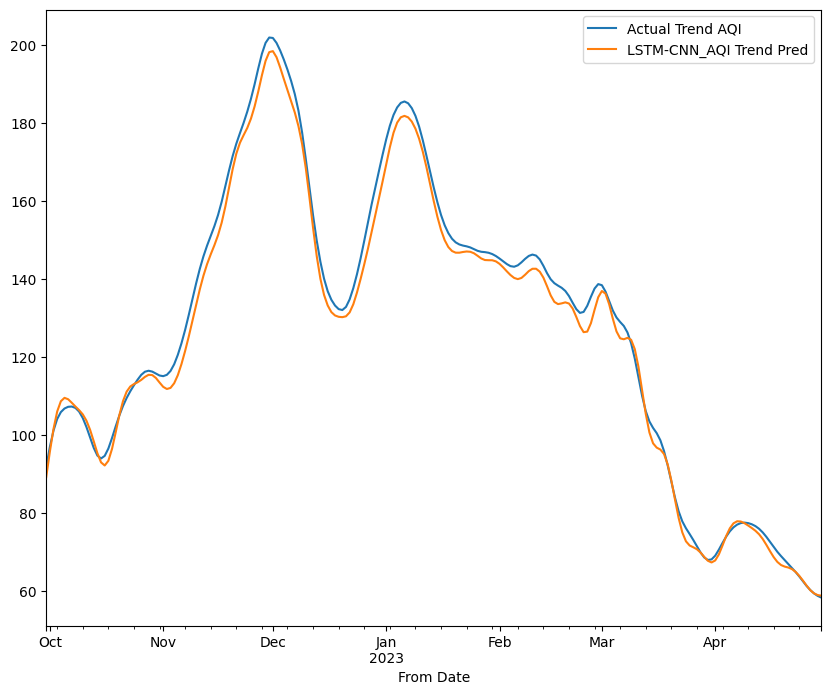

In [1114]:
trend_pred[['Trend','Aqi_Trend_Pred']].plot()
# Modifying the legend
legend = plt.legend(loc='upper right')  # Get the legend object
# Modify individual legend labels
labels = ['Actual Trend AQI', 'LSTM-CNN_AQI Trend Pred']
for text, label in zip(legend.get_texts(), labels):
    text.set_text(label)  # Set the new label text

In [1115]:
# df_final[['AQI_calculated','predReconAQI']].plot()


In [1116]:
trueAqi = trend_pred['Trend']

forcastAQI = trend_pred['Aqi_Trend_Pred']

test_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',test_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

RMSE =  3.2983787418193327
Mean =  127.89135094509689
MAPE =  0.020611486471165136
R2 Score =  0.9918993832461499


In [1117]:
# trendmodel.save("TrendRMSE3.29,MAPE0.02,R20.99.h5")

#### Forecasting for next 31 days


In [1118]:
%%capture
trend_test_predictions = []

first_eval_batch = trend_scaled_test[-win_length:]
current_batch = first_eval_batch.reshape((1,win_length,num_features))

for i in range(win_length):
    current_pred = trendmodel.predict(current_batch)[0]
    trend_test_predictions.append(current_pred)
    new_input = np.append(current_batch[:,1:,:],[[current_pred]] , axis=1)
    current_batch = new_input

In [1119]:
current_pred.shape

(3,)

In [1120]:
true_predictions = scaler.inverse_transform(trend_test_predictions)

In [1121]:
true_predictions = pd.DataFrame(data=true_predictions,columns=trendtest.columns)


In [1122]:
import datetime
start_date = datetime.date(2023,5,1)
end_date = start_date + datetime.timedelta(days=win_length-1)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
ndf = pd.DataFrame({'Dates':date_range})
fin = pd.concat([ndf,true_predictions],axis=1)


In [1123]:
dict = {'PM2.5_Trend': 'PM2.5TrendPred',
        'PM10_Trend': 'PM10_Trend_Pred',
        'Trend': 'TrendPred'}
# Renaming
fin.rename(columns=dict,
          inplace=True)

In [1124]:
fin

Dates  PM2.5TrendPred  PM10_Trend_Pred  TrendPred
0  2023-05-01       12.076120        38.416743  58.867707
1  2023-05-02       11.799791        37.676519  58.518735
2  2023-05-03       11.394586        36.924763  58.379549
3  2023-05-04       11.022107        36.362755  58.634792
4  2023-05-05       10.722066        35.845394  58.876061
5  2023-05-06       10.485122        35.412187  59.236688
6  2023-05-07       10.295155        35.043528  59.697829
7  2023-05-08       10.159894        34.736851  60.243816
8  2023-05-09       10.072941        34.480904  60.864452
9  2023-05-10       10.033140        34.312779  61.530819
10 2023-05-11       10.032293        34.212824  62.224583
11 2023-05-12       10.062420        34.155461  62.927703
12 2023-05-13       10.114213        34.122328  63.616381
13 2023-05-14       10.178984        34.095454  64.268829
14 2023-05-15       10.249562        34.058993  64.865446
15 2023-05-16       10.320509        34.001498  65.390277
16 2023-05-17       10.388284        33.915787  65.831985
17 2023-05-18       10.451288        33.798964  66.184195
18 2023-05-19       10.509640        33.652162  66.445497
19 2023-05-20       10.564842        33.479962  66.619101
20 2023-05-21       10.619392        33.289600  66.712190
21 2023-05-22       10.676306        33.090075  66.735224
22 2023-05-23       10.738693        32.891227  66.700871
23 2023-05-24       10.809359        32.702817  66.623007
24 2023-05-25       10.890490        32.533788  66.515803
25 2023-05-26       10.983439        32.391637  66.392874
26 2023-05-27       11.088640        32.282028  66.266608
27 2023-05-28       11.205491        32.208524  66.147609
28 2023-05-29       11.332477        32.172536  66.044335
29 2023-05-30       11.467303        32.173414  65.963007
30 2023-05-31       11.607111        32.208824  65.907624

In [1125]:
actualTrendForecast = true_forecast1[['From Date','PM2.5_Trend',	'PM10_Trend', 'Trend']]

fin.set_index('Dates', inplace=True)
actualTrendForecast.set_index('From Date', inplace=True)
actualTrendForecast[['PM2.5TrendPred',	'PM10_Trend_Pred'	,'TrendPred']] = fin[['PM2.5TrendPred',	'PM10_Trend_Pred'	,'TrendPred']]

In [1126]:
actualTrendForecast

PM2.5_Trend  PM10_Trend      Trend  PM2.5TrendPred  \
From Date                                                        
2023-05-01    13.155412   39.282665  58.254823       12.076120   
2023-05-02    12.948058   39.339431  58.507594       11.799791   
2023-05-03    12.847072   40.101633  59.253273       11.394586   
2023-05-04    12.921078   41.652313  60.437349       11.022107   
2023-05-05    13.173533   43.871209  61.938730       10.722066   
2023-05-06    13.594521   46.578539  63.660502       10.485122   
2023-05-07    14.148716   49.510978  65.488080       10.295155   
2023-05-08    14.750715   52.301756  67.230965       10.159894   
2023-05-09    15.291200   54.639932  68.683196       10.072941   
2023-05-10    15.676743   56.341459  69.752354       10.033140   
2023-05-11    15.865417   57.366733  70.450389       10.032293   
2023-05-12    15.877921   57.781077  70.835969       10.062420   
2023-05-13    15.744836   57.619219  70.938878       10.114213   
2023-05-14    15.483482   56.833162  70.749704       10.178984   
2023-05-15    15.119756   55.388404  70.301279       10.249562   
2023-05-16    14.688536   53.343310  69.660895       10.320509   
2023-05-17    14.229180   50.861450  68.858625       10.388284   
2023-05-18    13.759310   48.164530  68.002757       10.451288   
2023-05-19    13.304598   45.549838  67.255335       10.509640   
2023-05-20    12.904099   43.321907  66.788491       10.564842   
2023-05-21    12.898068   43.070024  67.651016       10.619392   
2023-05-22    12.944281   43.056360  68.695215       10.676306   
2023-05-23    13.003768   43.064116  69.771532       10.738693   
2023-05-24    13.079126   43.105194  70.876172       10.809359   
2023-05-25    13.176071   43.212103  72.024468       10.890490   
2023-05-26    13.298134   43.410288  73.229962       10.983439   
2023-05-27    13.446877   43.715811  74.500887       11.088640   
2023-05-28    13.620932   44.133278  75.838235       11.205491   
2023-05-29    13.818311   44.661567  77.239115       11.332477   
2023-05-30    14.037752   45.297938  78.701624       11.467303   
2023-05-31    14.278320   46.036567  80.225921       11.607111   

            PM10_Trend_Pred  TrendPred  
From Date                               
2023-05-01        38.416743  58.867707  
2023-05-02        37.676519  58.518735  
2023-05-03        36.924763  58.379549  
2023-05-04        36.362755  58.634792  
2023-05-05        35.845394  58.876061  
2023-05-06        35.412187  59.236688  
2023-05-07        35.043528  59.697829  
2023-05-08        34.736851  60.243816  
2023-05-09        34.480904  60.864452  
2023-05-10        34.312779  61.530819  
2023-05-11        34.212824  62.224583  
2023-05-12        34.155461  62.927703  
2023-05-13        34.122328  63.616381  
2023-05-14        34.095454  64.268829  
2023-05-15        34.058993  64.865446  
2023-05-16        34.001498  65.390277  
2023-05-17        33.915787  65.831985  
2023-05-18        33.798964  66.184195  
2023-05-19        33.652162  66.445497  
2023-05-20        33.479962  66.619101  
2023-05-21        33.289600  66.712190  
2023-05-22        33.090075  66.735224  
2023-05-23        32.891227  66.700871  
2023-05-24        32.702817  66.623007  
2023-05-25        32.533788  66.515803  
2023-05-26        32.391637  66.392874  
2023-05-27        32.282028  66.266608  
2023-05-28        32.208524  66.147609  
2023-05-29        32.172536  66.044335  
2023-05-30        32.173414  65.963007  
2023-05-31        32.208824  65.907624

<Axes: xlabel='From Date'>

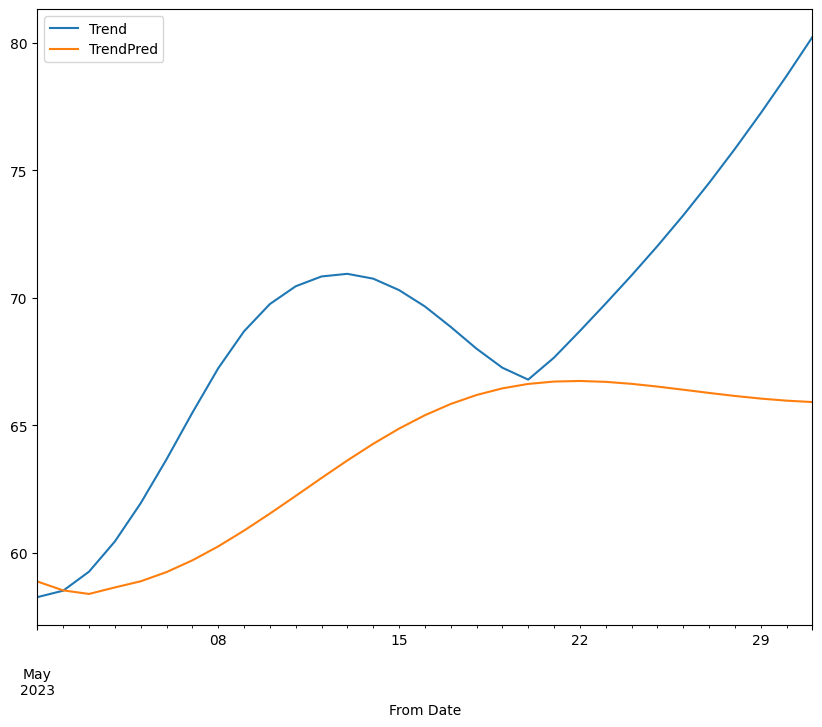

In [1127]:
actualTrendForecast[['Trend', 'TrendPred']].plot()

RMSE =  6.46286978025883
Mean =  63.65269657310112
MAPE =  0.08254553414660358
R2 Score =  -0.42362764448517987


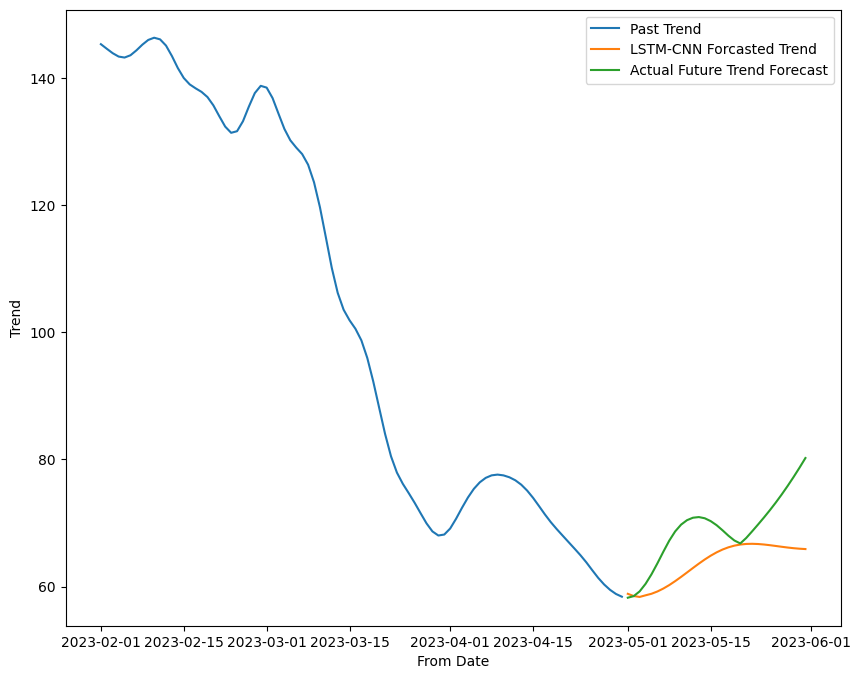

In [1128]:
import seaborn as sns

# forcastAQI = fin[['Trend']]
forcastAQI = actualTrendForecast[['Trend']]
# trueAqi = true_forecast1[['Trend']]
trueAqi = actualTrendForecast[['TrendPred']]

original = final_df[['From Date', 'Trend']]
original['From Date']=pd.to_datetime(original['From Date'])
original = original.loc[original['From Date'] >= '2023-02-01']

sns.lineplot(x=original['From Date'], y=original['Trend'], label = 'Past Trend')
# sns.lineplot(x=true_forecast1.index, y=true_forecast1['predReconAQI'],label = 'LSTM-CNN Forcasted AQI')
sns.lineplot(x=actualTrendForecast.index, y=actualTrendForecast['TrendPred'],label = 'LSTM-CNN Forcasted Trend')
sns.lineplot(x=actualTrendForecast.index, y=actualTrendForecast['Trend'],label = 'Actual Future Trend Forecast')
# sns.lineplot(x=true_forecast1['From Date'], y=true_forecast1['Trend'],label = 'Original Trend')
# plt.xticks(rotation=25)

forecast_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',forecast_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

### Seasonal Component

In [594]:
# Scaling and timeseries generator for seasonal
scaler = MinMaxScaler()
scaler.fit(seasonaltrain)

seasonal_scaled_train = scaler.transform(seasonaltrain)
seasonal_scaled_test = scaler.transform(seasonaltest)

win_length = 31
batch_size = 16
num_features = 3
seasonal_train_generator = TimeseriesGenerator(seasonal_scaled_train,seasonal_scaled_train, length = win_length,sampling_rate=1,batch_size=batch_size)
seasonal_test_generator = TimeseriesGenerator(seasonal_scaled_test,seasonal_scaled_test, length = win_length,sampling_rate=1,batch_size=batch_size)

In [595]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Define the model architecture
seasonalmodel = tf.keras.Sequential()
seasonalmodel.add(tf.keras.layers.SimpleRNN(128, input_shape=(win_length, num_features), return_sequences=True))
seasonalmodel.add(tf.keras.layers.SimpleRNN(128, return_sequences=True))
seasonalmodel.add(tf.keras.layers.SimpleRNN(96, return_sequences=False))
seasonalmodel.add(tf.keras.layers.Dense(seasonaltrain.shape[1]))

# Compile the model
seasonalmodel.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(learning_rate=0.001), metrics=[tf.metrics.RootMeanSquaredError(), tf.metrics.MeanAbsoluteError()])

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Generate validation data for evaluation during training
validation_generator = TimeseriesGenerator(seasonal_scaled_test, seasonal_scaled_test, length=win_length, batch_size=batch_size)

# Train the model
history = seasonalmodel.fit(seasonal_train_generator, epochs=50, validation_data=validation_generator, shuffle=False, callbacks=[early_stopping])

# Evaluate the model
# test_generator = TimeseriesGenerator(scaled_test, scaled_test, length=win_length, batch_size=batch_size)
test_loss, test_rmse, test_mae = seasonalmodel.evaluate(seasonal_test_generator)

print("Test Loss:", test_loss)
print("Test RMSE:", test_rmse)
print("Test MAE:", test_mae)


Epoch 1/50
59/59 [==============================] - 9s 60ms/step - loss: 0.0441 - root_mean_squared_error: 0.2099 - mean_absolute_error: 0.1316 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0814 - val_mean_absolute_error: 0.0643
Epoch 2/50
59/59 [==============================] - 2s 36ms/step - loss: 0.0088 - root_mean_squared_error: 0.0936 - mean_absolute_error: 0.0630 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0715 - val_mean_absolute_error: 0.0563
Epoch 3/50
59/59 [==============================] - 2s 34ms/step - loss: 0.0074 - root_mean_squared_error: 0.0862 - mean_absolute_error: 0.0572 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0606 - val_mean_absolute_error: 0.0472
Epoch 4/50
59/59 [==============================] - 2s 35ms/step - loss: 0.0068 - root_mean_squared_error: 0.0828 - mean_absolute_error: 0.0573 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0604 - val_mean_absolute_error: 0.0467
Epoch 5/50
59/59 [==============================] - 3s 43ms/

In [596]:
seasonalmodel.evaluate(seasonal_test_generator,verbose=0)

[0.0014585171593353152, 0.038190536201000214, 0.02978411130607128]

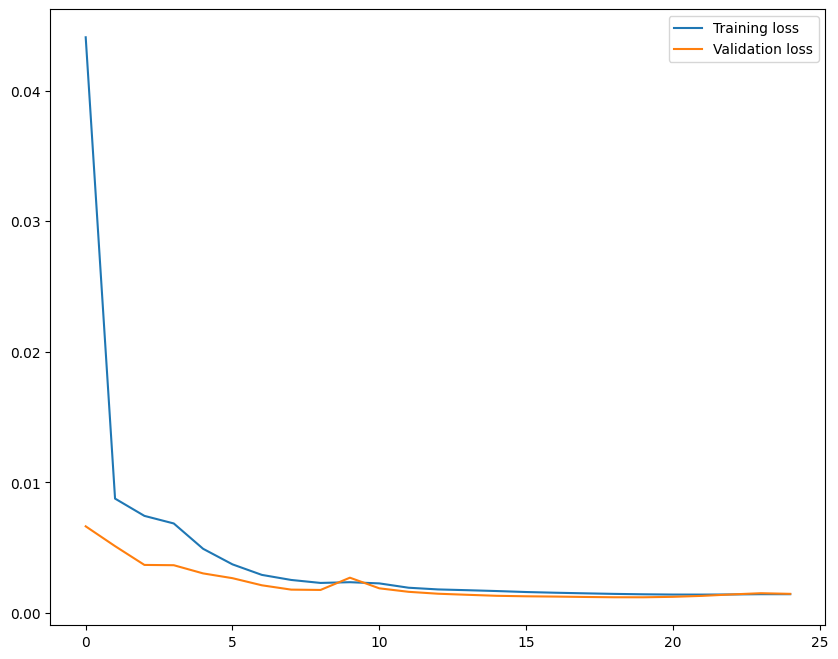

In [597]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

####  Train Prediction

In [598]:
# Load model
# seasonalmodel = tf.keras.models.load_model('/content/SeasonalRMSE5.08MAPE2.195R20.78.h5')

In [599]:
predictions=seasonalmodel.predict(seasonal_train_generator)

59/59 [==============================] - 1s 10ms/step


In [600]:
df_pred = pd.DataFrame(predictions)

In [601]:
rev_trans=scaler.inverse_transform(df_pred)

In [602]:
rev_trans

array([[ 3.1387851,  5.6611238,  0.6630824],
       [ 7.563194 , 15.629729 , 12.454825 ],
       [ 3.8840606, 12.088108 ,  4.9814253],
       ...,
       [ 1.8994417, 38.409916 , 29.523643 ],
       [ 2.2923765, 30.46214  , 28.522934 ],
       [ 2.0196273,  8.38959  ,  2.3521707]], dtype=float32)

In [603]:
df_final=seasonaltrain[31:972]
df_final

PM2.5_Seasonal  PM10_Seasonal   Seasonal
From Date                                           
2020-02-01        1.482902      -1.905063   2.614341
2020-02-02        5.129471       6.510009   8.946634
2020-02-03        0.819693       2.330659  -1.011721
2020-02-04       10.231973      15.961240  15.187631
2020-02-05       11.338849      30.702102  32.452529
...                    ...            ...        ...
2022-08-25       -1.417972      15.855156  12.709619
2022-08-26        0.536078      30.806545  32.340119
2022-08-27        0.739166      29.945075  34.319494
2022-08-28       -0.076185      19.977625  26.452544
2022-08-29        0.229376      -7.429110  -4.599623

[941 rows x 3 columns]

In [604]:
len(rev_trans[:,2])

941

In [605]:
df_final

PM2.5_Seasonal  PM10_Seasonal   Seasonal
From Date                                           
2020-02-01        1.482902      -1.905063   2.614341
2020-02-02        5.129471       6.510009   8.946634
2020-02-03        0.819693       2.330659  -1.011721
2020-02-04       10.231973      15.961240  15.187631
2020-02-05       11.338849      30.702102  32.452529
...                    ...            ...        ...
2022-08-25       -1.417972      15.855156  12.709619
2022-08-26        0.536078      30.806545  32.340119
2022-08-27        0.739166      29.945075  34.319494
2022-08-28       -0.076185      19.977625  26.452544
2022-08-29        0.229376      -7.429110  -4.599623

[941 rows x 3 columns]

In [606]:
df_final['Aqi_Seasonal_Pred']=rev_trans[:,2]

<Axes: xlabel='From Date'>

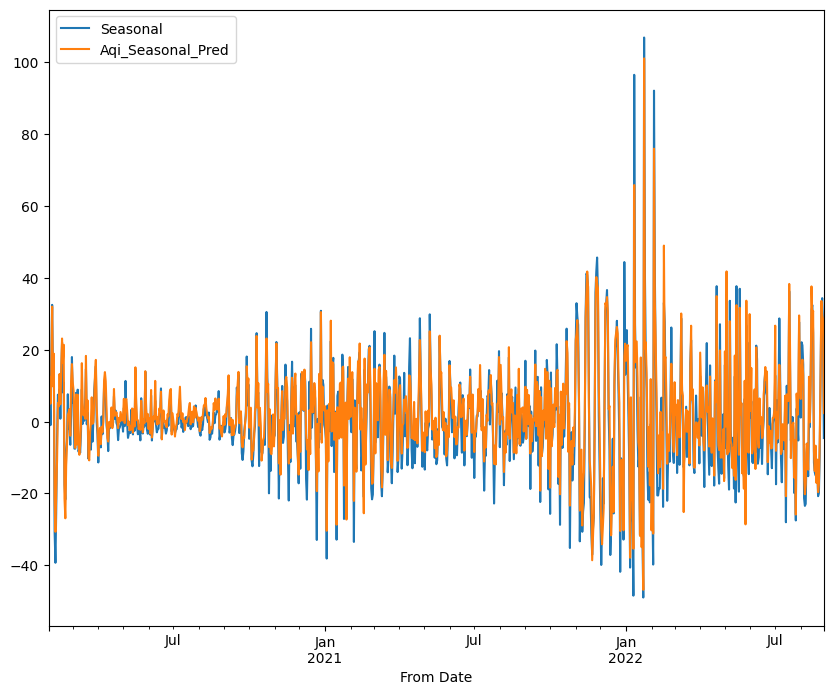

In [607]:
df_final[['Seasonal','Aqi_Seasonal_Pred']].plot()

In [608]:
trueAqi = df_final['Seasonal']

forcastAQI = df_final['Aqi_Seasonal_Pred']

train_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',train_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

RMSE =  5.2242111760233065
Mean =  0.0757099684256811
MAPE =  1.6520225588373947
R2 Score =  0.8414186627878913


#### Test Prediction

In [630]:
predictions=seasonalmodel.predict(seasonal_test_generator)

14/14 [==============================] - 0s 9ms/step


In [631]:
# seasonalmodel.save('SeasonalModel_R20.82.h5')

In [632]:
df_pred = pd.DataFrame(predictions)

In [633]:
rev_trans=scaler.inverse_transform(df_pred)
len(rev_trans)

213

In [634]:
seasonal_pred=seasonal_data[predictions.shape[0]*-1:]
seasonal_pred

PM2.5_Seasonal  PM10_Seasonal   Seasonal
From Date                                           
2022-09-30       -0.059100       0.950876  -8.736704
2022-10-01        5.045913       6.843102   3.887277
2022-10-02       -2.858521      -5.055256  -3.137905
2022-10-03       -1.613568      13.362426   7.043241
2022-10-04       -0.053614      33.020727  31.119720
...                    ...            ...        ...
2023-04-26       -1.243064      -4.951746  -2.573020
2023-04-27       -1.816547      -2.309499  -5.503315
2023-04-28       -4.065124      -5.577720  -9.015584
2023-04-29       -0.906466       5.831679  -0.619943
2023-04-30        2.438097      12.312518   4.031722

[213 rows x 3 columns]

In [635]:
seasonal_pred['Aqi_Seasonal_Pred']=rev_trans[:,2]
seasonal_pred['PM10_Seasonal_Pred']=rev_trans[:,1]
seasonal_pred['PM2.5_Seasonal_Pred']=rev_trans[:,0]

In [636]:
seasonal_pred

PM2.5_Seasonal  PM10_Seasonal   Seasonal  Aqi_Seasonal_Pred  \
From Date                                                                 
2022-09-30       -0.059100       0.950876  -8.736704          -8.865097   
2022-10-01        5.045913       6.843102   3.887277          -4.458779   
2022-10-02       -2.858521      -5.055256  -3.137905          -4.387619   
2022-10-03       -1.613568      13.362426   7.043241           5.744860   
2022-10-04       -0.053614      33.020727  31.119720          34.947342   
...                    ...            ...        ...                ...   
2023-04-26       -1.243064      -4.951746  -2.573020           0.097066   
2023-04-27       -1.816547      -2.309499  -5.503315          -3.089523   
2023-04-28       -4.065124      -5.577720  -9.015584          -9.530640   
2023-04-29       -0.906466       5.831679  -0.619943          -4.327043   
2023-04-30        2.438097      12.312518   4.031722           0.342526   

            PM10_Seasonal_Pred  PM2.5_Seasonal_Pred  
From Date                                            
2022-09-30           -0.599986            -1.003409  
2022-10-01            0.801267             2.643905  
2022-10-02           -1.258401            -1.914086  
2022-10-03           12.656756            -2.324072  
2022-10-04           39.476032             1.131429  
...                        ...                  ...  
2023-04-26            0.755587            -0.165770  
2023-04-27            0.236890            -2.563552  
2023-04-28           -2.700367            -4.277974  
2023-04-29            4.402008            -2.267026  
2023-04-30           10.916723            -0.152570  

[213 rows x 6 columns]

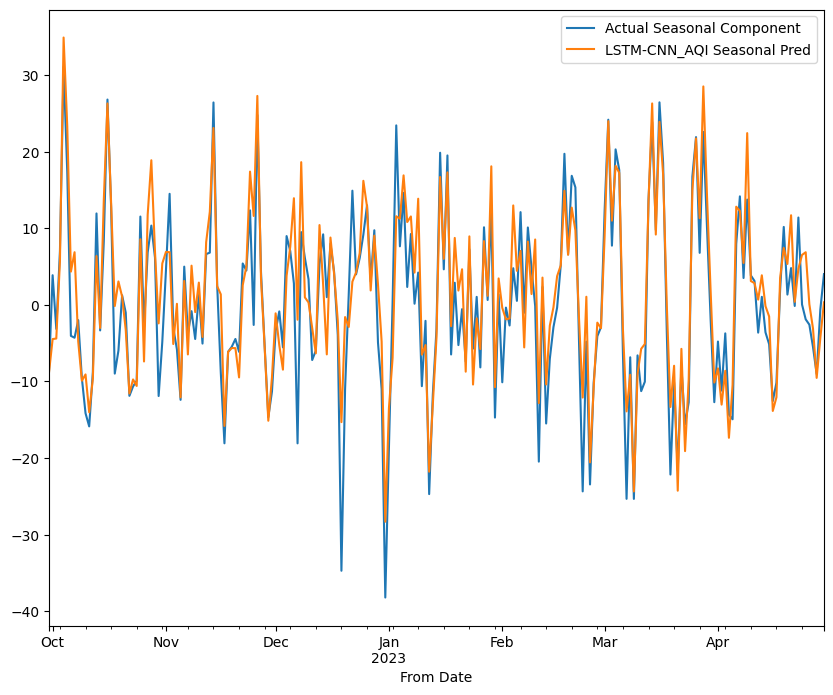

In [637]:
seasonal_pred[['Seasonal','Aqi_Seasonal_Pred']].plot()
# Modifying the legend
legend = plt.legend(loc='upper right')  # Get the legend object
# Modify individual legend labels
labels = ['Actual Seasonal Component', 'LSTM-CNN_AQI Seasonal Pred']
for text, label in zip(legend.get_texts(), labels):
    text.set_text(label)  # Set the new label text

In [640]:
# df_final[['AQI_calculated','predReconAQI']].plot()
seasonalmodel.save("SeasonalRMSE5.07MAPE1.96R2 0.784.h5")

In [639]:
trueAqi = seasonal_pred['Seasonal']

forcastAQI = seasonal_pred['Aqi_Seasonal_Pred']

test_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',test_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

RMSE =  5.071458234945898
Mean =  0.06640082211904468
MAPE =  1.9628427337090504
R2 Score =  0.7841432950313119


#### Forecasting for next 31 days


In [619]:
%%capture
seasonal_test_predictions = []

first_eval_batch = seasonal_scaled_test[-win_length:]
current_batch = first_eval_batch.reshape((1,win_length,num_features))

for i in range(win_length):
    current_pred = seasonalmodel.predict(current_batch)[0]
    seasonal_test_predictions.append(current_pred)
    new_input = np.append(current_batch[:,1:,:],[[current_pred]] , axis=1)
    current_batch = new_input

In [620]:
current_pred.shape

(3,)

In [621]:
true_predictions = scaler.inverse_transform(seasonal_test_predictions)

In [622]:
true_predictions = pd.DataFrame(data=true_predictions,columns=seasonaltest.columns)


In [623]:
import datetime
start_date = datetime.date(2023,5,1)
end_date = start_date + datetime.timedelta(days=win_length-1)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
ndf = pd.DataFrame({'Dates':date_range})
fin = pd.concat([ndf,true_predictions],axis=1)


In [624]:
dict = {'PM2.5_Seasonal': 'PM2.5SeasonalPred',
        'PM10_Seasonal': 'PM10_Seasonal_Pred',
        'Seasonal': 'SeasonalPred'}
# Renaming
fin.rename(columns=dict,
          inplace=True)

In [625]:
fin

Dates  PM2.5SeasonalPred  PM10_Seasonal_Pred  SeasonalPred
0  2023-05-01           3.251235           17.706746      9.593250
1  2023-05-02           1.676401            8.817097      3.432652
2  2023-05-03           2.194942            5.471648      4.403366
3  2023-05-04           0.709903            0.067396     -1.253791
4  2023-05-05          -1.234487            4.019751      8.016269
5  2023-05-06           0.755988            1.102727      1.529799
6  2023-05-07           2.737973            0.451281     -2.635860
7  2023-05-08          -0.271306           -2.598782     -3.085136
8  2023-05-09          -3.099223           -2.395553     -7.841784
9  2023-05-10          -3.765693           -3.853718     -9.160947
10 2023-05-11          -0.345907            7.068200     -0.072117
11 2023-05-12           1.212995            9.376781      0.849210
12 2023-05-13           1.737277           12.611463      6.473197
13 2023-05-14           1.809778           11.082617      5.452901
14 2023-05-15           1.987371            9.403050      7.201989
15 2023-05-16           1.614246            4.643653      2.008420
16 2023-05-17          -0.037885            7.726291      7.716093
17 2023-05-18           2.061994            5.883092      5.728286
18 2023-05-19           3.305748            4.370651      1.191777
19 2023-05-20           0.244076           -1.170249     -2.010889
20 2023-05-21          -4.407222           -4.170452     -9.872585
21 2023-05-22          -3.728609           -5.106194     -9.901684
22 2023-05-23          -1.077165            2.228998     -3.721110
23 2023-05-24          -0.626143            2.109257     -5.416484
24 2023-05-25           0.531677            6.670930      2.271744
25 2023-05-26           1.711209           10.442039      5.599540
26 2023-05-27           2.257641           11.520218      9.176913
27 2023-05-28           2.993322            8.579781      6.024460
28 2023-05-29           1.139032           10.553878      8.717615
29 2023-05-30           3.255661           11.155686     10.576336
30 2023-05-31           3.486285            8.952740      5.704377

In [626]:
actualSeasonalForecast = true_forecast1[['From Date','PM2.5_Seasonal',	'PM10_Seasonal'	, 'Seasonal']]

fin.set_index('Dates', inplace=True)
actualSeasonalForecast.set_index('From Date', inplace=True)
actualSeasonalForecast[['PM2.5SeasonalPred',	'PM10_Seasonal_Pred'	,'SeasonalPred']] = fin[['PM2.5SeasonalPred',	'PM10_Seasonal_Pred'	,'SeasonalPred']]

In [627]:
actualSeasonalForecast

PM2.5_Seasonal  PM10_Seasonal   Seasonal  PM2.5SeasonalPred  \
From Date                                                                 
2023-05-01        2.870118      11.098653   7.685428           3.251235   
2023-05-02       -0.542407      -0.855686  -1.792674           1.676401   
2023-05-03        1.341389      -3.770118  -3.474626           2.194942   
2023-05-04        0.254632      -4.777262  -3.782111           0.709903   
2023-05-05       -1.929136      -4.871166   7.979282          -1.234487   
2023-05-06        0.135635      -5.093634   4.973118           0.755988   
2023-05-07        0.523857      -1.607695  -3.078367           2.737973   
2023-05-08       -0.041757      -4.589645  -0.998720          -0.271306   
2023-05-09        0.162522      -0.300800  -4.155647          -3.099223   
2023-05-10       -2.166362      -0.188302  -5.103140          -3.765693   
2023-05-11        0.935309      13.731686   7.287567          -0.345907   
2023-05-12        2.485898      11.820886   4.999854           1.212995   
2023-05-13        0.323931       1.786990   4.364440           1.737277   
2023-05-14       -1.775620      -1.595862  -4.021645           1.809778   
2023-05-15       -0.735987      -7.637472 -11.324272           1.987371   
2023-05-16       -0.278531      -6.887381  -7.946813           1.614246   
2023-05-17       -1.618393      -4.064801   3.915532          -0.037885   
2023-05-18        1.177516      -3.614131  11.571546           2.061994   
2023-05-19       -1.398687      -2.660628  -3.946999           3.305748   
2023-05-20        0.804997      -5.565251  -0.035923           0.244076   
2023-05-21        2.046531       1.776465  -2.228875          -4.407222   
2023-05-22       -0.214260       4.867574  -1.078531          -3.728609   
2023-05-23        2.726587      21.908160  15.396280          -1.077165   
2023-05-24        2.677815      11.916002   6.339620          -0.626143   
2023-05-25       -2.292854      -7.913395   0.860868           0.531677   
2023-05-26       -2.634259      -1.392432  -5.844705           1.711209   
2023-05-27       -2.235288     -10.408233 -18.682372           2.257641   
2023-05-28       -0.482359      -8.253045 -11.802135           2.993322   
2023-05-29       -1.399323      -3.538270  -1.884325           1.139032   
2023-05-30        1.935346      -2.121452  18.356634           3.255661   
2023-05-31       -3.458879      -3.368560  -4.342284           3.486285   

            PM10_Seasonal_Pred  SeasonalPred  
From Date                                     
2023-05-01           17.706746      9.593250  
2023-05-02            8.817097      3.432652  
2023-05-03            5.471648      4.403366  
2023-05-04            0.067396     -1.253791  
2023-05-05            4.019751      8.016269  
2023-05-06            1.102727      1.529799  
2023-05-07            0.451281     -2.635860  
2023-05-08           -2.598782     -3.085136  
2023-05-09           -2.395553     -7.841784  
2023-05-10           -3.853718     -9.160947  
2023-05-11            7.068200     -0.072117  
2023-05-12            9.376781      0.849210  
2023-05-13           12.611463      6.473197  
2023-05-14           11.082617      5.452901  
2023-05-15            9.403050      7.201989  
2023-05-16            4.643653      2.008420  
2023-05-17            7.726291      7.716093  
2023-05-18            5.883092      5.728286  
2023-05-19            4.370651      1.191777  
2023-05-20           -1.170249     -2.010889  
2023-05-21           -4.170452     -9.872585  
2023-05-22           -5.106194     -9.901684  
2023-05-23            2.228998     -3.721110  
2023-05-24            2.109257     -5.416484  
2023-05-25            6.670930      2.271744  
2023-05-26           10.442039      5.599540  
2023-05-27           11.520218      9.176913  
2023-05-28            8.579781      6.024460  
2023-05-29           10.553878      8.717615  
2023-05-30           11.155686     10.576336  
2023-05-31            8.952740  

<Axes: xlabel='From Date'>

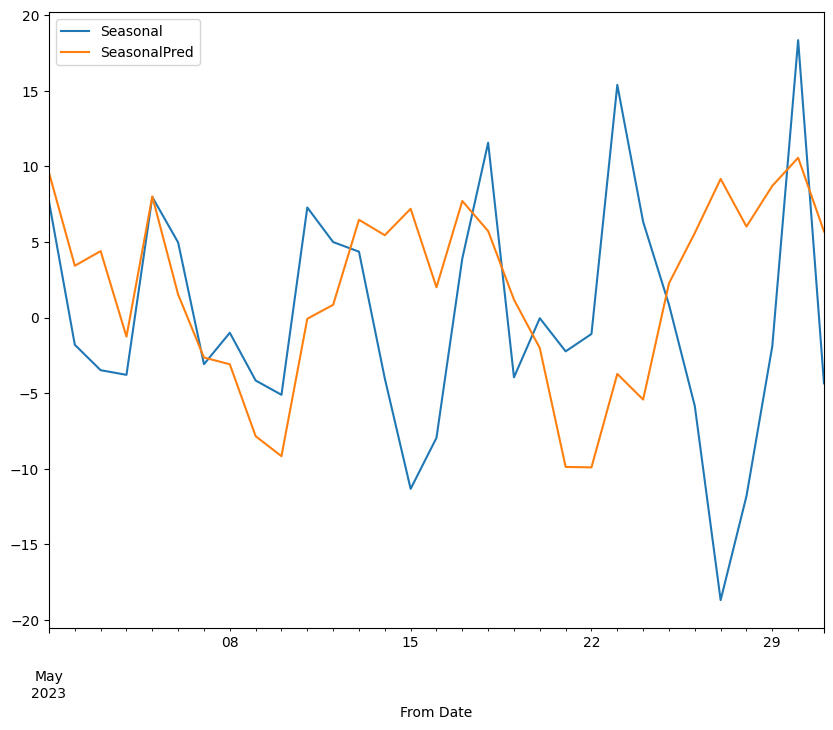

In [628]:
actualSeasonalForecast[['Seasonal', 'SeasonalPred']].plot()

RMSE =  9.793683631414828
Mean =  1.8288970965268279
MAPE =  4.974990121578145
R2 Score =  -0.5932640250538228


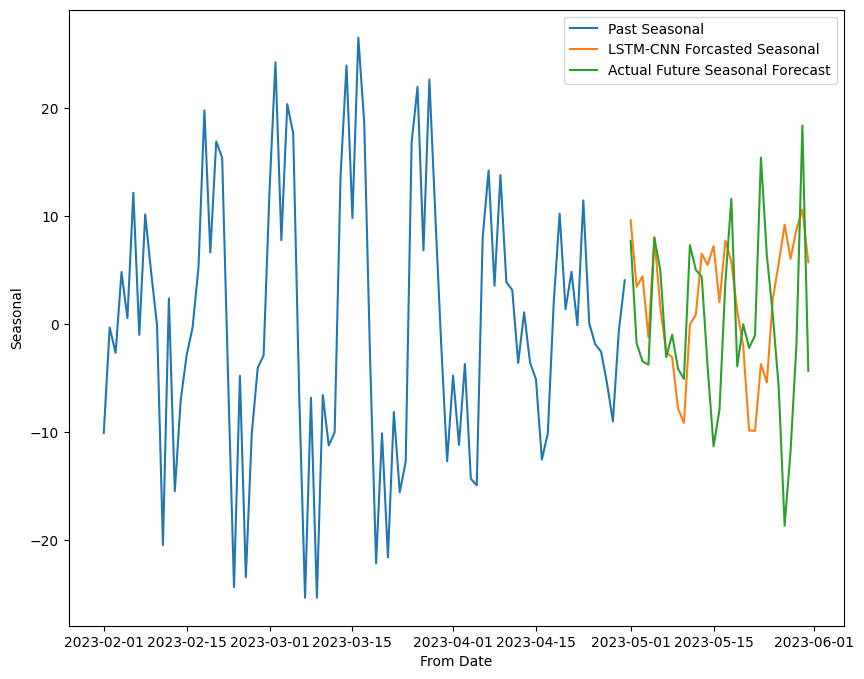

In [629]:
import seaborn as sns

# forcastAQI = fin[['Seasonal']]
forcastAQI = actualSeasonalForecast[['Seasonal']]
# trueAqi = true_forecast1[['Seasonal']]
trueAqi = actualSeasonalForecast[['SeasonalPred']]

original = final_df[['From Date', 'Seasonal']]
original['From Date']=pd.to_datetime(original['From Date'])
original = original.loc[original['From Date'] >= '2023-02-01']

sns.lineplot(x=original['From Date'], y=original['Seasonal'], label = 'Past Seasonal')
# sns.lineplot(x=true_forecast1.index, y=true_forecast1['predReconAQI'],label = 'LSTM-CNN Forcasted AQI')
sns.lineplot(x=actualSeasonalForecast.index, y=actualSeasonalForecast['SeasonalPred'],label = 'LSTM-CNN Forcasted Seasonal')
sns.lineplot(x=actualSeasonalForecast.index, y=actualSeasonalForecast['Seasonal'],label = 'Actual Future Seasonal Forecast')
# sns.lineplot(x=true_forecast1['From Date'], y=true_forecast1['Seasonal'],label = 'Original Seasonal')
# plt.xticks(rotation=25)

forecast_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',forecast_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

### Residual Component

In [764]:
# Scaling and timeseries generator for residual
scaler = MinMaxScaler()
scaler.fit(residualtrain)

residual_scaled_train = scaler.transform(residualtrain)
residual_scaled_test = scaler.transform(residualtest)

win_length = 31
batch_size = 24
num_features = 3
residual_train_generator = TimeseriesGenerator(residual_scaled_train,residual_scaled_train, length = win_length,sampling_rate=1,batch_size=batch_size)
residual_test_generator = TimeseriesGenerator(residual_scaled_test,residual_scaled_test, length = win_length,sampling_rate=1,batch_size=batch_size)

In [765]:
import tensorflow as tf
import keras
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Define the model architecture
residualmodel = tf.keras.Sequential()
residualmodel.add(SimpleRNN(128, input_shape=(win_length, num_features), return_sequences=True))
residualmodel.add(SimpleRNN(128, return_sequences=True))
residualmodel.add(SimpleRNN(64, return_sequences=False))
residualmodel.add(Dense(residual_scaled_train.shape[1]))

# Compile the model
residualmodel.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(learning_rate=0.001), metrics=[tf.metrics.RootMeanSquaredError(), tf.metrics.MeanAbsoluteError()])

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Generate validation data for evaluation during training
validation_generator = TimeseriesGenerator(residual_scaled_test, residual_scaled_test, length=win_length, batch_size=batch_size)

# Train the model
history = residualmodel.fit(residual_train_generator, epochs=50, validation_data=validation_generator, shuffle=False, callbacks=[early_stopping])

# Evaluate the model
# test_generator = TimeseriesGenerator(scaled_test, scaled_test, length=win_length, batch_size=batch_size)
test_loss, test_rmse, test_mae = residualmodel.evaluate(residual_test_generator)

print("Test Loss:", test_loss)
print("Test RMSE:", test_rmse)
print("Test MAE:", test_mae)


Epoch 1/50
40/40 [==============================] - 8s 47ms/step - loss: 0.0650 - root_mean_squared_error: 0.2550 - mean_absolute_error: 0.1515 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0695 - val_mean_absolute_error: 0.0537
Epoch 2/50
40/40 [==============================] - 2s 45ms/step - loss: 0.0053 - root_mean_squared_error: 0.0728 - mean_absolute_error: 0.0500 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0603 - val_mean_absolute_error: 0.0448
Epoch 3/50
40/40 [==============================] - 2s 58ms/step - loss: 0.0049 - root_mean_squared_error: 0.0700 - mean_absolute_error: 0.0471 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0585 - val_mean_absolute_error: 0.0433
Epoch 4/50
40/40 [==============================] - 1s 36ms/step - loss: 0.0047 - root_mean_squared_error: 0.0688 - mean_absolute_error: 0.0463 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0569 - val_mean_absolute_error: 0.0421
Epoch 5/50
40/40 [==============================] - 1s 35ms/

In [766]:
residualmodel.evaluate(residual_test_generator,verbose=0)

[0.0019145471742376685, 0.04375553876161575, 0.034516334533691406]

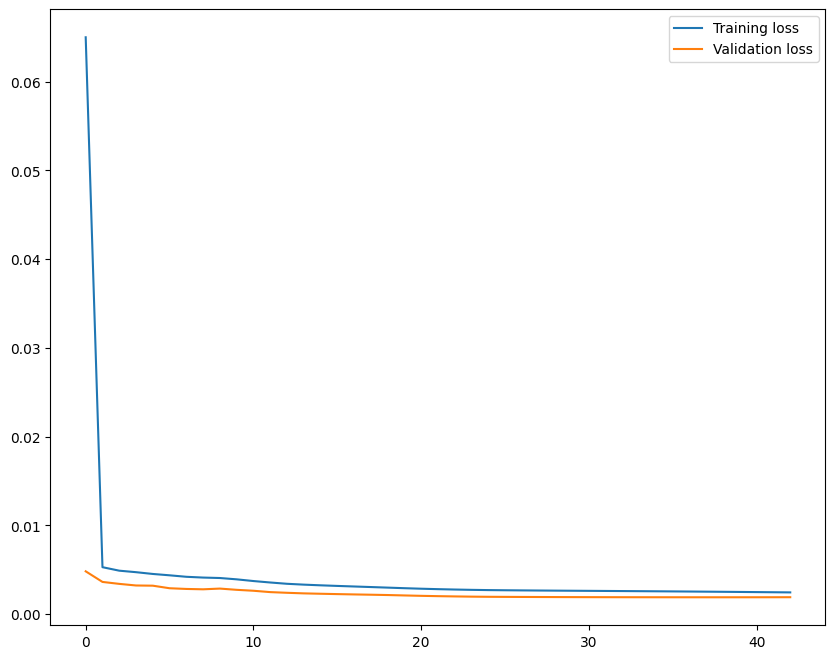

In [767]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

####  Train Prediction

In [768]:
# load model residual
# residualmodel = tf.keras.models.load_model('/content/ResidualRMSE 15.11MAPE2.32R20.208.h5')

In [769]:
# residualmodel.summary()

In [770]:
predictions=residualmodel.predict(residual_train_generator)

40/40 [==============================] - 1s 13ms/step


In [771]:
df_pred = pd.DataFrame(predictions)

In [772]:
rev_trans=scaler.inverse_transform(df_pred)

In [773]:
df_final=residualtrain[31:972]
df_final

PM2.5_Residual  PM10_Residual   Residual
From Date                                           
2020-02-01        7.838595      15.410785   6.117004
2020-02-02       10.695244      19.787048  25.729604
2020-02-03       15.251844       7.481701  36.182652
2020-02-04        1.665668     -13.406633   5.876853
2020-02-05      -12.654722     -25.309956 -36.719164
...                    ...            ...        ...
2022-08-25        0.351784      55.800428  51.846559
2022-08-26       -0.276430     -24.965058 -33.580493
2022-08-27        0.134787     -23.920545 -33.874099
2022-08-28       -1.313295     -34.203757 -34.055038
2022-08-29       -0.336687      -5.564722   1.538655

[941 rows x 3 columns]

In [774]:
len(rev_trans[:,2])

941

In [775]:
df_final

PM2.5_Residual  PM10_Residual   Residual
From Date                                           
2020-02-01        7.838595      15.410785   6.117004
2020-02-02       10.695244      19.787048  25.729604
2020-02-03       15.251844       7.481701  36.182652
2020-02-04        1.665668     -13.406633   5.876853
2020-02-05      -12.654722     -25.309956 -36.719164
...                    ...            ...        ...
2022-08-25        0.351784      55.800428  51.846559
2022-08-26       -0.276430     -24.965058 -33.580493
2022-08-27        0.134787     -23.920545 -33.874099
2022-08-28       -1.313295     -34.203757 -34.055038
2022-08-29       -0.336687      -5.564722   1.538655

[941 rows x 3 columns]

In [776]:
df_final['Aqi_residual_Pred']=rev_trans[:,2]

<Axes: xlabel='From Date'>

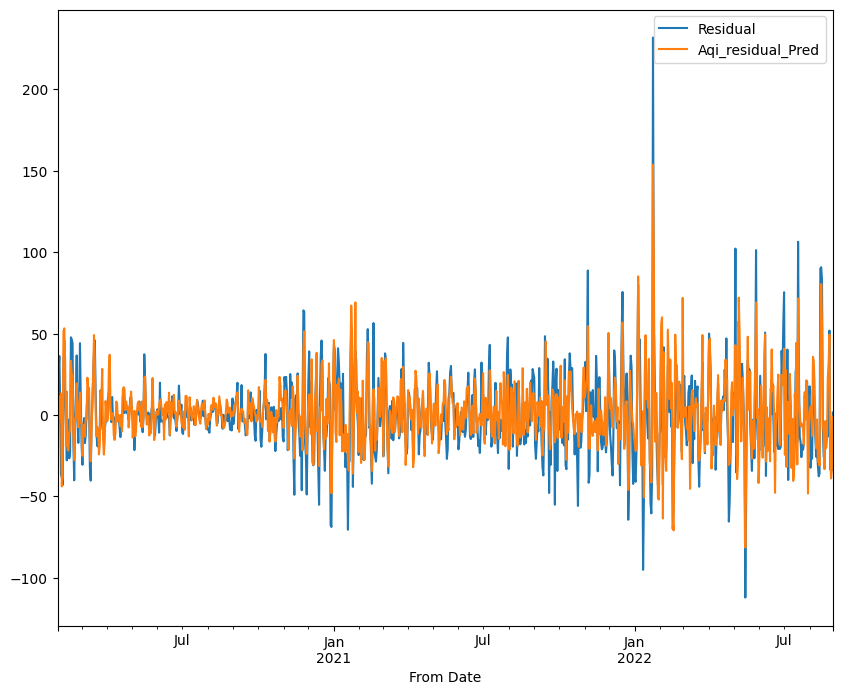

In [777]:
df_final[['Residual','Aqi_residual_Pred']].plot()

In [778]:
trueAqi = df_final['Residual']

forcastAQI = df_final['Aqi_residual_Pred']

train_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',train_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

RMSE =  16.00996618569344
Mean =  -0.021752340404478418
MAPE =  5.266063893096239
R2 Score =  0.3851912518560531


#### Test Prediction

In [779]:
predictions=residualmodel.predict(residual_test_generator)

9/9 [==============================] - 0s 9ms/step


In [780]:
df_pred = pd.DataFrame(predictions)

In [781]:
rev_trans=scaler.inverse_transform(df_pred)
len(rev_trans)

213

In [782]:
residual_pred=residual_data[predictions.shape[0]*-1:]
residual_pred

PM2.5_Residual  PM10_Residual   Residual
From Date                                           
2022-09-30        3.961014       9.691437   3.243017
2022-10-01       -1.847490      -4.723571 -19.424750
2022-10-02      -12.108180     -16.523461 -25.094930
2022-10-03       -9.973518     -18.090451 -24.718520
2022-10-04       -6.440298      69.609349  62.939643
...                    ...            ...        ...
2023-04-26        6.409815      19.921467   5.199372
2023-04-27        3.885366      11.006193   4.831681
2023-04-28        2.274769       1.894025   0.187913
2023-04-29       -0.090593     -10.254611  -4.392265
2023-04-30       -6.723584     -17.807335  -8.279211

[213 rows x 3 columns]

In [783]:
residual_pred['Aqi_residual_Pred'] = rev_trans[:,2]
residual_pred['PM10_residual_Pred'] = rev_trans[:,1]
residual_pred['PM2.5_residual_Pred'] = rev_trans[:,0]

In [784]:
residual_pred

PM2.5_Residual  PM10_Residual   Residual  Aqi_residual_Pred  \
From Date                                                                 
2022-09-30        3.961014       9.691437   3.243017          20.037714   
2022-10-01       -1.847490      -4.723571 -19.424750          -8.945633   
2022-10-02      -12.108180     -16.523461 -25.094930         -12.625635   
2022-10-03       -9.973518     -18.090451 -24.718520          -0.805816   
2022-10-04       -6.440298      69.609349  62.939643          22.478401   
...                    ...            ...        ...                ...   
2023-04-26        6.409815      19.921467   5.199372           4.740510   
2023-04-27        3.885366      11.006193   4.831681          28.698282   
2023-04-28        2.274769       1.894025   0.187913          -1.303892   
2023-04-29       -0.090593     -10.254611  -4.392265           6.409531   
2023-04-30       -6.723584     -17.807335  -8.279211           0.450031   

            PM10_residual_Pred  PM2.5_residual_Pred  
From Date                                            
2022-09-30           15.902846             6.847434  
2022-10-01           -4.206390            -3.503169  
2022-10-02           -7.338768            -6.474776  
2022-10-03           -3.933901            -3.895542  
2022-10-04           16.761135            -1.712357  
...                        ...                  ...  
2023-04-26            2.388648             3.063031  
2023-04-27           22.509817             9.028219  
2023-04-28           -3.759587             1.176673  
2023-04-29            0.526034             1.663594  
2023-04-30           -6.443363            -4.698865  

[213 rows x 6 columns]

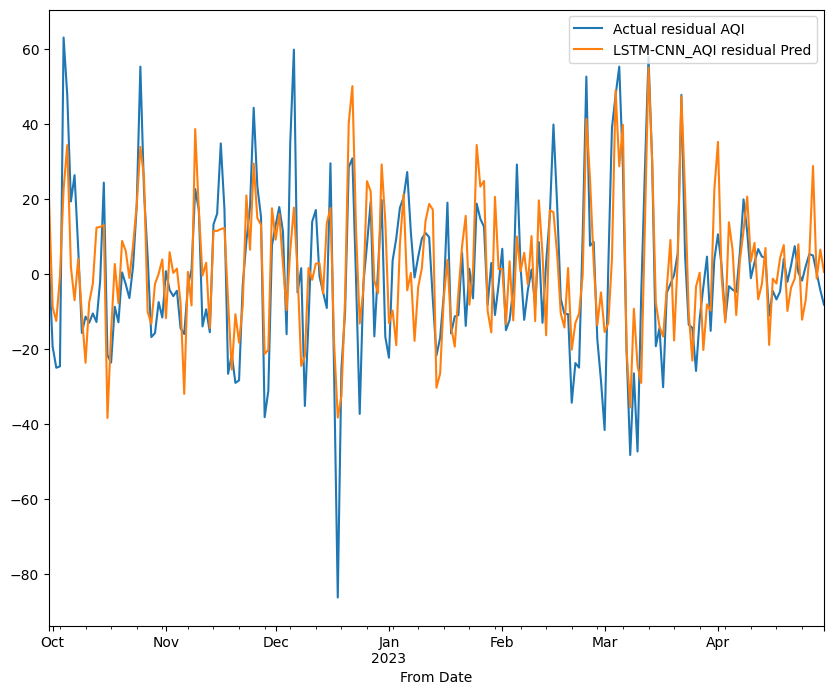

In [785]:
residual_pred[['Residual','Aqi_residual_Pred']].plot()
# Modifying the legend
legend = plt.legend(loc='upper right')  # Get the legend object
# Modify individual legend labels
labels = ['Actual residual AQI', 'LSTM-CNN_AQI residual Pred']
for text, label in zip(legend.get_texts(), labels):
    text.set_text(label)  # Set the new label text

In [786]:
# df_final[['AQI_calculated','predReconAQI']].plot()


In [787]:
trueAqi = residual_pred['Residual']

forcastAQI = residual_pred['Aqi_residual_Pred']

test_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',test_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

RMSE =  14.203934026338848
Mean =  0.19550108322002255
MAPE =  2.1055829330472333
R2 Score =  0.3205984420539354


In [839]:
residualmodel.save("ResidualRMSE14.20MAPE2.10R20.32.h5")

#### Forecasting for next 31 days


In [789]:
%%capture
residual_test_predictions = []

first_eval_batch = residual_scaled_test[-win_length:]
current_batch = first_eval_batch.reshape((1,win_length,num_features))

for i in range(win_length):
    current_pred = residualmodel.predict(current_batch)[0]
    residual_test_predictions.append(current_pred)
    new_input = np.append(current_batch[:,1:,:],[[current_pred]] , axis=1)
    current_batch = new_input

In [790]:
current_pred.shape

(3,)

In [791]:
true_predictions = scaler.inverse_transform(residual_test_predictions)

In [792]:
true_predictions = pd.DataFrame(data=true_predictions,columns=residualtest.columns)


In [793]:
import datetime
start_date = datetime.date(2023,5,1)
end_date = start_date + datetime.timedelta(days=win_length-1)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
ndf = pd.DataFrame({'Dates':date_range})
fin = pd.concat([ndf,true_predictions],axis=1)


In [794]:
dict = {'PM2.5_Residual': 'PM2.5ResidualPred',
        'PM10_Residual': 'PM10_Residual_Pred',
        'Residual': 'ResidualPred'}
# Renaming
fin.rename(columns=dict,
          inplace=True)

In [795]:
fin

Dates  PM2.5ResidualPred  PM10_Residual_Pred  ResidualPred
0  2023-05-01          -8.426070          -20.838478    -14.865245
1  2023-05-02           0.946376           -0.915823      1.992270
2  2023-05-03           2.450748           -0.751583     -4.530619
3  2023-05-04           2.153363            5.821506      2.500952
4  2023-05-05           1.435528            2.669535      8.131895
5  2023-05-06           2.739343            3.884390     10.036486
6  2023-05-07          -4.953626          -11.831416     -5.077137
7  2023-05-08          -7.651375          -17.343375    -13.359559
8  2023-05-09          -0.429993           -0.612930      2.709754
9  2023-05-10           2.629416            2.760115      5.832746
10 2023-05-11           3.252931            9.503487     10.391699
11 2023-05-12           5.661727            8.573176     11.140783
12 2023-05-13           2.701450            3.870764      5.035036
13 2023-05-14          -0.999946           -1.838272      1.030128
14 2023-05-15           1.243848            3.641913     11.279595
15 2023-05-16           0.653161           -3.345650      2.912812
16 2023-05-17          -3.028772           -9.312417     -8.699959
17 2023-05-18          -6.449730          -14.240012    -13.113855
18 2023-05-19          -1.040533           -2.924444      2.175882
19 2023-05-20           4.407973            6.026157     10.691538
20 2023-05-21          -0.914791           -8.146112     -5.113588
21 2023-05-22          -3.448079           -6.942001     -6.075976
22 2023-05-23          -2.923507           -6.214292     -5.168553
23 2023-05-24          -0.796097           -0.741930      0.623109
24 2023-05-25           4.157293            6.113367     14.115415
25 2023-05-26           1.211802           -0.604925      4.392169
26 2023-05-27          -2.597069           -7.357136     -5.263600
27 2023-05-28          -3.524187           -6.056602     -4.100215
28 2023-05-29           2.227770            3.705413      9.177965
29 2023-05-30           5.800832           10.013521     14.310545
30 2023-05-31           3.562041            2.350497      4.558960

In [796]:
actualResidualForecast = true_forecast1[['From Date','PM2.5_Residual',	'PM10_Residual'	, 'Residual']]

fin.set_index('Dates', inplace=True)
actualResidualForecast.set_index('From Date', inplace=True)
actualResidualForecast[['PM2.5ResidualPred',	'PM10_Residual_Pred'	,'ResidualPred']] = fin[['PM2.5ResidualPred',	'PM10_Residual_Pred'	,'ResidualPred']]

In [797]:
actualResidualForecast

PM2.5_Residual  PM10_Residual   Residual  PM2.5ResidualPred  \
From Date                                                                 
2023-05-01       -7.042196     -17.336318  -7.773584          -8.426070   
2023-05-02       -3.262318     -13.910412  -9.881586           0.946376   
2023-05-03       -4.513461     -10.771515 -13.778647           2.450748   
2023-05-04       -1.777376      -6.140051 -13.988571           2.153363   
2023-05-05        0.775603       2.634957  24.248654           1.435528   
2023-05-06        3.283177       0.121762  -0.633620           2.739343   
2023-05-07       -2.924240     -16.971616 -10.409713          -4.953626   
2023-05-08       -0.358958      -4.375444  -6.898911          -7.651375   
2023-05-09       -2.255388      -0.939132  -0.360883          -0.429993   
2023-05-10        3.049619       9.718510   4.017453           2.629416   
2023-05-11        5.655941      36.818247  25.095377           3.252931   
2023-05-12        5.614514      32.054704  19.830845           5.661727   
2023-05-13        4.779566      16.087124   7.196683           2.701450   
2023-05-14       -4.356195      -7.163966  -7.394726          -0.999946   
2023-05-15        3.502897       2.184068  -1.643674           1.243848   
2023-05-16        4.131662       7.854071   7.952584           0.653161   
2023-05-17       -0.180787      -9.118316  -6.274157          -3.028772   
2023-05-18       -4.663493      -8.035400 -17.074303          -6.449730   
2023-05-19       -3.685912      -5.875877  -2.141670          -1.040533   
2023-05-20       -2.809096      -6.708323   1.080766           4.407973   
2023-05-21        0.002067      -2.781489  -0.255475          -0.914791   
2023-05-22       -2.761688      -8.585600  -3.116684          -3.448079   
2023-05-23       -4.245355     -22.508943 -16.501146          -2.923507   
2023-05-24       -1.918608     -16.109529 -11.215792          -0.796097   
2023-05-25       -1.863217      -7.692041  -3.885336           4.157293   
2023-05-26        5.239459      12.167144   8.948077           1.211802   
2023-05-27        0.655078       4.962422   5.848153          -2.597069   
2023-05-28       -1.483573      -1.610233  -1.869433          -3.524187   
2023-05-29       -0.518988       4.985036  -7.854790           2.227770   
2023-05-30        1.283569       5.610180  12.108408           5.800832   
2023-05-31        2.797226       9.430327   4.783029           3.562041   

            PM10_Residual_Pred  ResidualPred  
From Date                                     
2023-05-01          -20.838478    -14.865245  
2023-05-02           -0.915823      1.992270  
2023-05-03           -0.751583     -4.530619  
2023-05-04            5.821506      2.500952  
2023-05-05            2.669535      8.131895  
2023-05-06            3.884390     10.036486  
2023-05-07          -11.831416     -5.077137  
2023-05-08          -17.343375    -13.359559  
2023-05-09           -0.612930      2.709754  
2023-05-10            2.760115      5.832746  
2023-05-11            9.503487     10.391699  
2023-05-12            8.573176     11.140783  
2023-05-13            3.870764      5.035036  
2023-05-14           -1.838272      1.030128  
2023-05-15            3.641913     11.279595  
2023-05-16           -3.345650      2.912812  
2023-05-17           -9.312417     -8.699959  
2023-05-18          -14.240012    -13.113855  
2023-05-19           -2.924444      2.175882  
2023-05-20            6.026157     10.691538  
2023-05-21           -8.146112     -5.113588  
2023-05-22           -6.942001     -6.075976  
2023-05-23           -6.214292     -5.168553  
2023-05-24           -0.741930      0.623109  
2023-05-25            6.113367     14.115415  
2023-05-26           -0.604925      4.392169  
2023-05-27           -7.357136     -5.263600  
2023-05-28           -6.056602     -4.100215  
2023-05-29            3.705413      9.177965  
2023-05-30           10.013521     14.310545  
2023-05-31            2.350497  

<Axes: xlabel='From Date'>

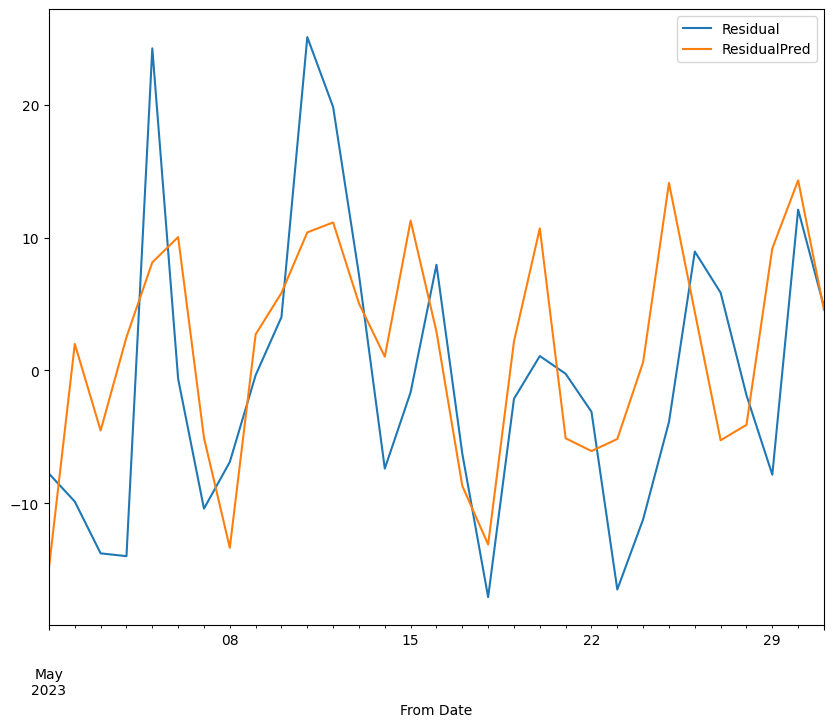

In [798]:
actualResidualForecast[['Residual', 'ResidualPred']].plot()

RMSE =  9.447234336382284
Mean =  1.5377882195543668
MAPE =  2.190114027665447
R2 Score =  0.2299293411491009


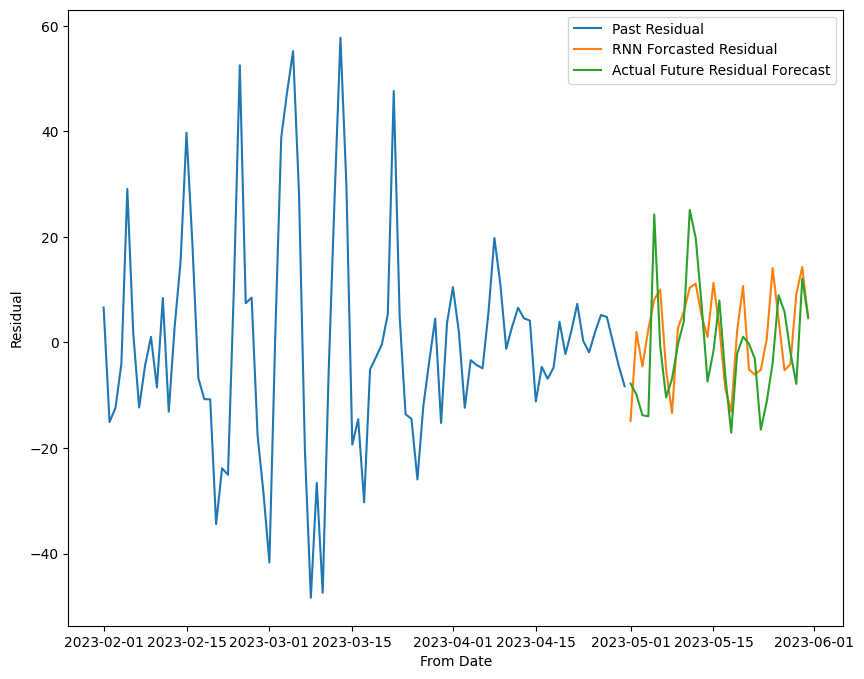

In [799]:
import seaborn as sns

# forcastAQI = fin[['Residual']]
forcastAQI = actualResidualForecast[['Residual']]
# trueAqi = true_forecast1[['Residual']]
trueAqi = actualResidualForecast[['ResidualPred']]

original = final_df[['From Date', 'Residual']]
original['From Date']=pd.to_datetime(original['From Date'])
original = original.loc[original['From Date'] >= '2023-02-01']

sns.lineplot(x=original['From Date'], y=original['Residual'], label = 'Past Residual')
# sns.lineplot(x=true_forecast1.index, y=true_forecast1['predReconAQI'],label = 'LSTM-CNN Forcasted AQI')
sns.lineplot(x=actualResidualForecast.index, y=actualResidualForecast['ResidualPred'],label = 'RNN Forcasted Residual')
sns.lineplot(x=actualResidualForecast.index, y=actualResidualForecast['Residual'],label = 'Actual Future Residual Forecast')
# sns.lineplot(x=true_forecast1['From Date'], y=true_forecast1['Residual'],label = 'Original Residual')
# plt.xticks(rotation=25)

forecast_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',forecast_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

In [800]:
len(trend_scaled_train)

972

In [801]:
len(trend_train_generator)

79

In [802]:
X,y = trend_train_generator[0]

In [803]:
X.shape

(12, 31, 3)

In [804]:
y.shape

(12, 3)

### Ensemble Learning Model

In [805]:
trend_pred,seasonal_pred,residual_pred

(            PM2.5_Trend  PM10_Trend       Trend  Aqi_Trend_Pred  \
 From Date                                                         
 2022-09-30    18.713086   41.652687   91.827020       89.270271   
 2022-10-01    20.474911   44.557136   97.037472       95.821518   
 2022-10-02    22.156701   46.737050  101.232835      101.657890   
 2022-10-03    23.563752   48.231358  104.175279      106.098038   
 2022-10-04    24.587245   49.289925  105.940637      108.723717   
 ...                 ...         ...         ...             ...   
 2023-04-26    14.721583   44.256946   61.373648       61.467911   
 2023-04-27    14.191181   42.608305   60.338300       60.308678   
 2023-04-28    13.822022   41.320361   59.494338       59.496895   
 2023-04-29    13.578726   40.366265   58.845542       59.053013   
 2023-04-30    13.377154   39.691484   58.414155       58.885315   
 
             PM10_Trend_Pred  PM2.5_Trend_Pred  
 From Date                                      
 2022-09-30     

#### Calculate AQI Predictions

In [806]:
aqipred = trend_pred['Aqi_Trend_Pred'] + seasonal_pred['Aqi_Seasonal_Pred'] + residual_pred['Aqi_residual_Pred']

In [807]:
actual = final_df.iloc[-213:]
actual = actual[['From Date','AQI_calculated']]
actual.set_index('From Date',inplace = True)

In [808]:
actual['AQI_Pred'] = aqipred

<Axes: xlabel='From Date'>

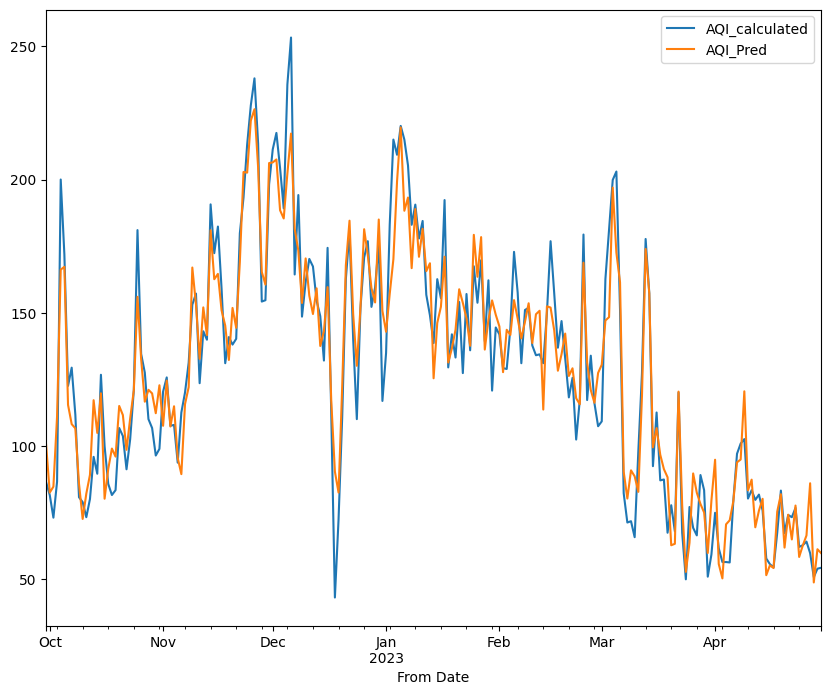

In [809]:
actual[['AQI_calculated','AQI_Pred']].plot()

In [810]:
trueAqi = actual['AQI_calculated']

forcastAQI = actual['AQI_Pred']

test_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',test_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

RMSE =  13.68930675724127
Mean =  128.15325285043593
MAPE =  0.09612271778189829
R2 Score =  0.892593451434073


#### AQI Forecasting

In [811]:
# Forecast
actualTrendForecast,actualSeasonalForecast,actualResidualForecast

(            PM2.5_Trend  PM10_Trend      Trend  PM2.5TrendPred  \
 From Date                                                        
 2023-05-01    13.155412   39.282665  58.254823       12.076120   
 2023-05-02    12.948058   39.339431  58.507594       11.799791   
 2023-05-03    12.847072   40.101633  59.253273       11.394586   
 2023-05-04    12.921078   41.652313  60.437349       11.022107   
 2023-05-05    13.173533   43.871209  61.938730       10.722066   
 2023-05-06    13.594521   46.578539  63.660502       10.485122   
 2023-05-07    14.148716   49.510978  65.488080       10.295155   
 2023-05-08    14.750715   52.301756  67.230965       10.159894   
 2023-05-09    15.291200   54.639932  68.683196       10.072941   
 2023-05-10    15.676743   56.341459  69.752354       10.033140   
 2023-05-11    15.865417   57.366733  70.450389       10.032293   
 2023-05-12    15.877921   57.781077  70.835969       10.062420   
 2023-05-13    15.744836   57.619219  70.938878       10.11421

In [812]:
actualForecast = true_forecast1
actualForecast = actualForecast[['From Date','PM2.5','PM10','AQI_calculated']]
actualForecast.set_index('From Date',inplace = True)
actualForecast

PM2.5        PM10  AQI_calculated
From Date                                        
2023-05-01   8.983333   33.045000       58.166667
2023-05-02   9.143333   24.573333       46.833333
2023-05-03   9.675000   25.560000       42.000000
2023-05-04  11.398333   30.735000       42.666667
2023-05-05  12.020000   41.635000       94.166667
2023-05-06  17.013333   41.606667       68.000000
2023-05-07  11.748333   30.931667       52.000000
2023-05-08  14.350000   43.336667       59.333333
2023-05-09  13.198333   53.400000       64.166667
2023-05-10  16.560000   65.871667       68.666667
2023-05-11  22.456667  107.916667      102.833333
2023-05-12  23.978333  101.656667       95.666667
2023-05-13  20.848333   75.493333       82.500000
2023-05-14   9.351667   48.073333       59.333333
2023-05-15  17.886667   49.935000       57.333333
2023-05-16  18.541667   54.310000       69.666667
2023-05-17  12.430000   37.678333       66.500000
2023-05-18  10.273333   36.515000       62.500000
2023-05-19   8.220000   37.013333       61.166667
2023-05-20  10.900000   31.048333       67.833333
2023-05-21  14.946667   42.065000       65.166667
2023-05-22   9.968333   39.338333       64.500000
2023-05-23  11.485000   42.463333       68.666667
2023-05-24  13.838333   38.911667       66.000000
2023-05-25   9.020000   27.606667       69.000000
2023-05-26  15.903333   54.185000       76.333333
2023-05-27  11.866667   38.270000       61.666667
2023-05-28  11.655000   34.270000       62.166667
2023-05-29  11.900000   46.108333       67.500000
2023-05-30  17.256667   48.786667      109.166667
2023-05-31  13.616667   52.098333       80.666667

In [813]:
actualForecast['ModelForecastAQI'] = actualTrendForecast['TrendPred']+actualSeasonalForecast['SeasonalPred'] + actualResidualForecast['ResidualPred']
actualForecast

PM2.5        PM10  AQI_calculated  ModelForecastAQI
From Date                                                          
2023-05-01   8.983333   33.045000       58.166667         53.595712
2023-05-02   9.143333   24.573333       46.833333         63.943658
2023-05-03   9.675000   25.560000       42.000000         58.252296
2023-05-04  11.398333   30.735000       42.666667         59.881953
2023-05-05  12.020000   41.635000       94.166667         75.024225
2023-05-06  17.013333   41.606667       68.000000         70.802973
2023-05-07  11.748333   30.931667       52.000000         51.984832
2023-05-08  14.350000   43.336667       59.333333         43.799120
2023-05-09  13.198333   53.400000       64.166667         55.732422
2023-05-10  16.560000   65.871667       68.666667         58.202618
2023-05-11  22.456667  107.916667      102.833333         72.544166
2023-05-12  23.978333  101.656667       95.666667         74.917696
2023-05-13  20.848333   75.493333       82.500000         75.124614
2023-05-14   9.351667   48.073333       59.333333         70.751859
2023-05-15  17.886667   49.935000       57.333333         83.347030
2023-05-16  18.541667   54.310000       69.666667         70.311508
2023-05-17  12.430000   37.678333       66.500000         64.848119
2023-05-18  10.273333   36.515000       62.500000         58.798627
2023-05-19   8.220000   37.013333       61.166667         69.813156
2023-05-20  10.900000   31.048333       67.833333         75.299750
2023-05-21  14.946667   42.065000       65.166667         51.726017
2023-05-22   9.968333   39.338333       64.500000         50.757563
2023-05-23  11.485000   42.463333       68.666667         57.811208
2023-05-24  13.838333   38.911667       66.000000         61.829632
2023-05-25   9.020000   27.606667       69.000000         82.902961
2023-05-26  15.903333   54.185000       76.333333         76.384582
2023-05-27  11.866667   38.270000       61.666667         70.179921
2023-05-28  11.655000   34.270000       62.166667         68.071855
2023-05-29  11.900000   46.108333       67.500000         83.939915
2023-05-30  17.256667   48.786667      109.166667         90.849888
2023-05-31  13.616667   52.098333       80.666667         76.170961

In [814]:
original = final_df[['From Date', 'AQI_calculated']]
original['From Date']=pd.to_datetime(original['From Date'])
original = original.loc[original['From Date'] >= '2023-02-01']
original

From Date  AQI_calculated
1127 2023-02-01      141.833333
1128 2023-02-02      129.166667
1129 2023-02-03      128.833333
1130 2023-02-04      144.166667
1131 2023-02-05      172.833333
...         ...             ...
1211 2023-04-26       64.000000
1212 2023-04-27       59.666667
1213 2023-04-28       50.666667
1214 2023-04-29       53.833333
1215 2023-04-30       54.166667

[89 rows x 2 columns]

<Axes: xlabel='From Date'>

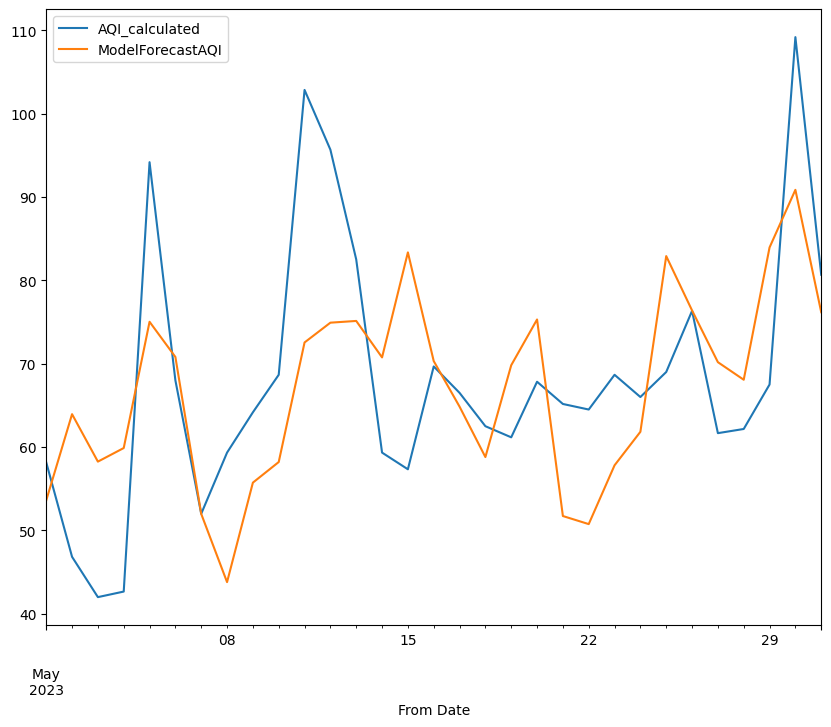

In [815]:
actualForecast[['AQI_calculated','ModelForecastAQI']].plot()


RMSE =  13.269611370938035
Mean =  67.01938188918231
MAPE =  0.16469907801266873
R2 Score =  0.26010939662312915


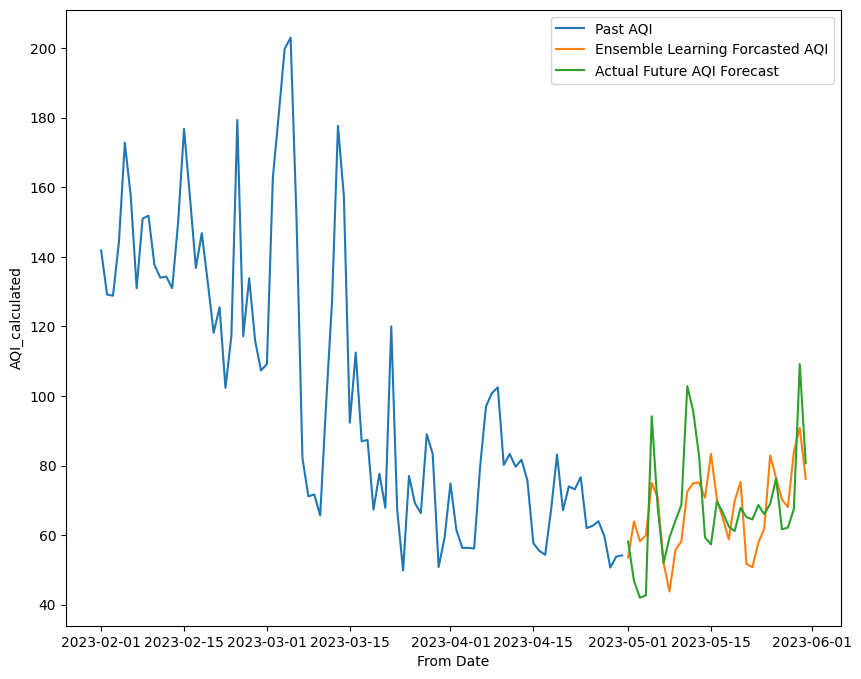

In [816]:
import seaborn as sns

forcastAQI = actualForecast[['AQI_calculated']]
trueAqi = actualForecast[['ModelForecastAQI']]

original = final_df[['From Date', 'AQI_calculated']]
original['From Date']=pd.to_datetime(original['From Date'])
original = original.loc[original['From Date'] >= '2023-02-01']

sns.lineplot(x=original['From Date'], y=original['AQI_calculated'], label = 'Past AQI')
sns.lineplot(x=actualForecast.index, y=actualForecast['ModelForecastAQI'],label = 'Ensemble Learning Forcasted AQI')
sns.lineplot(x=actualForecast.index, y=actualForecast['AQI_calculated'],label = 'Actual Future AQI Forecast')
# sns.lineplot(x=true_forecast1['From Date'], y=true_forecast1['Residual'],label = 'Original Residual')
# plt.xticks(rotation=25)

forecast_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',forecast_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

#### Calculate PM2.5 Predictions

In [817]:
trend_pred

PM2.5_Trend  PM10_Trend       Trend  Aqi_Trend_Pred  \
From Date                                                         
2022-09-30    18.713086   41.652687   91.827020       89.270271   
2022-10-01    20.474911   44.557136   97.037472       95.821518   
2022-10-02    22.156701   46.737050  101.232835      101.657890   
2022-10-03    23.563752   48.231358  104.175279      106.098038   
2022-10-04    24.587245   49.289925  105.940637      108.723717   
...                 ...         ...         ...             ...   
2023-04-26    14.721583   44.256946   61.373648       61.467911   
2023-04-27    14.191181   42.608305   60.338300       60.308678   
2023-04-28    13.822022   41.320361   59.494338       59.496895   
2023-04-29    13.578726   40.366265   58.845542       59.053013   
2023-04-30    13.377154   39.691484   58.414155       58.885315   

            PM10_Trend_Pred  PM2.5_Trend_Pred  
From Date                                      
2022-09-30        40.482296         18.019321  
2022-10-01        44.379108         19.176907  
2022-10-02        47.559105         20.376711  
2022-10-03        49.681652         21.487473  
2022-10-04        50.673000         22.377094  
...                     ...               ...  
2023-04-26        45.244957         13.316392  
2023-04-27        42.973454         12.731305  
2023-04-28        41.128056         12.310943  
2023-04-29        39.789719         12.087572  
2023-04-30        38.922176         12.032257  

[213 rows x 6 columns]

In [818]:
pm25pred = trend_pred['PM2.5_Trend_Pred'] + seasonal_pred['PM2.5_Seasonal_Pred'] + residual_pred['PM2.5_residual_Pred']

In [819]:
actual = final_df.iloc[-213:]
actual = actual[['From Date','PM2.5']]
actual.set_index('From Date',inplace = True)

In [820]:
actual['PM2.5_Pred'] = pm25pred

<Axes: xlabel='From Date'>

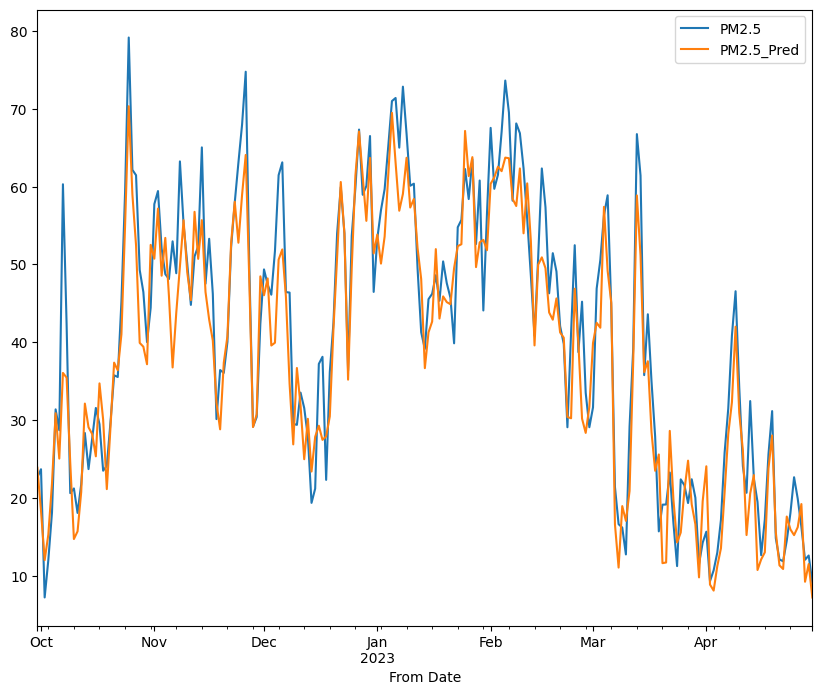

In [821]:
actual[['PM2.5','PM2.5_Pred']].plot()

In [822]:
trueAqi = actual['PM2.5']

forcastAQI = actual['PM2.5_Pred']

test_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',test_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

RMSE =  5.9108071423256385
Mean =  41.001222892913034
MAPE =  0.13347588111793493
R2 Score =  0.8689977594292542


#### PM2.5 Forecasting

In [823]:
# Forecast
actualTrendForecast,actualSeasonalForecast,actualResidualForecast

(            PM2.5_Trend  PM10_Trend      Trend  PM2.5TrendPred  \
 From Date                                                        
 2023-05-01    13.155412   39.282665  58.254823       12.076120   
 2023-05-02    12.948058   39.339431  58.507594       11.799791   
 2023-05-03    12.847072   40.101633  59.253273       11.394586   
 2023-05-04    12.921078   41.652313  60.437349       11.022107   
 2023-05-05    13.173533   43.871209  61.938730       10.722066   
 2023-05-06    13.594521   46.578539  63.660502       10.485122   
 2023-05-07    14.148716   49.510978  65.488080       10.295155   
 2023-05-08    14.750715   52.301756  67.230965       10.159894   
 2023-05-09    15.291200   54.639932  68.683196       10.072941   
 2023-05-10    15.676743   56.341459  69.752354       10.033140   
 2023-05-11    15.865417   57.366733  70.450389       10.032293   
 2023-05-12    15.877921   57.781077  70.835969       10.062420   
 2023-05-13    15.744836   57.619219  70.938878       10.11421

In [824]:
actualForecast = true_forecast1
actualForecast = actualForecast[['From Date','PM2.5','PM10','AQI_calculated']]
actualForecast.set_index('From Date',inplace = True)
actualForecast

PM2.5        PM10  AQI_calculated
From Date                                        
2023-05-01   8.983333   33.045000       58.166667
2023-05-02   9.143333   24.573333       46.833333
2023-05-03   9.675000   25.560000       42.000000
2023-05-04  11.398333   30.735000       42.666667
2023-05-05  12.020000   41.635000       94.166667
2023-05-06  17.013333   41.606667       68.000000
2023-05-07  11.748333   30.931667       52.000000
2023-05-08  14.350000   43.336667       59.333333
2023-05-09  13.198333   53.400000       64.166667
2023-05-10  16.560000   65.871667       68.666667
2023-05-11  22.456667  107.916667      102.833333
2023-05-12  23.978333  101.656667       95.666667
2023-05-13  20.848333   75.493333       82.500000
2023-05-14   9.351667   48.073333       59.333333
2023-05-15  17.886667   49.935000       57.333333
2023-05-16  18.541667   54.310000       69.666667
2023-05-17  12.430000   37.678333       66.500000
2023-05-18  10.273333   36.515000       62.500000
2023-05-19   8.220000   37.013333       61.166667
2023-05-20  10.900000   31.048333       67.833333
2023-05-21  14.946667   42.065000       65.166667
2023-05-22   9.968333   39.338333       64.500000
2023-05-23  11.485000   42.463333       68.666667
2023-05-24  13.838333   38.911667       66.000000
2023-05-25   9.020000   27.606667       69.000000
2023-05-26  15.903333   54.185000       76.333333
2023-05-27  11.866667   38.270000       61.666667
2023-05-28  11.655000   34.270000       62.166667
2023-05-29  11.900000   46.108333       67.500000
2023-05-30  17.256667   48.786667      109.166667
2023-05-31  13.616667   52.098333       80.666667

In [825]:
actualForecast['ModelForecastPM2.5'] = actualTrendForecast['PM2.5TrendPred']+actualSeasonalForecast['PM2.5SeasonalPred'] + actualResidualForecast['PM2.5ResidualPred']
actualForecast

PM2.5        PM10  AQI_calculated  ModelForecastPM2.5
From Date                                                            
2023-05-01   8.983333   33.045000       58.166667            6.901285
2023-05-02   9.143333   24.573333       46.833333           14.422567
2023-05-03   9.675000   25.560000       42.000000           16.040276
2023-05-04  11.398333   30.735000       42.666667           13.885374
2023-05-05  12.020000   41.635000       94.166667           10.923107
2023-05-06  17.013333   41.606667       68.000000           13.980452
2023-05-07  11.748333   30.931667       52.000000            8.079503
2023-05-08  14.350000   43.336667       59.333333            2.237214
2023-05-09  13.198333   53.400000       64.166667            6.543726
2023-05-10  16.560000   65.871667       68.666667            8.896862
2023-05-11  22.456667  107.916667      102.833333           12.939317
2023-05-12  23.978333  101.656667       95.666667           16.937143
2023-05-13  20.848333   75.493333       82.500000           14.552940
2023-05-14   9.351667   48.073333       59.333333           10.988817
2023-05-15  17.886667   49.935000       57.333333           13.480781
2023-05-16  18.541667   54.310000       69.666667           12.587915
2023-05-17  12.430000   37.678333       66.500000            7.321627
2023-05-18  10.273333   36.515000       62.500000            6.063552
2023-05-19   8.220000   37.013333       61.166667           12.774855
2023-05-20  10.900000   31.048333       67.833333           15.216892
2023-05-21  14.946667   42.065000       65.166667            5.297380
2023-05-22   9.968333   39.338333       64.500000            3.499618
2023-05-23  11.485000   42.463333       68.666667            6.738021
2023-05-24  13.838333   38.911667       66.000000            9.387119
2023-05-25   9.020000   27.606667       69.000000           15.579460
2023-05-26  15.903333   54.185000       76.333333           13.906450
2023-05-27  11.866667   38.270000       61.666667           10.749213
2023-05-28  11.655000   34.270000       62.166667           10.674627
2023-05-29  11.900000   46.108333       67.500000           14.699279
2023-05-30  17.256667   48.786667      109.166667           20.523796
2023-05-31  13.616667   52.098333       80.666667           18.655438

<Axes: xlabel='From Date'>

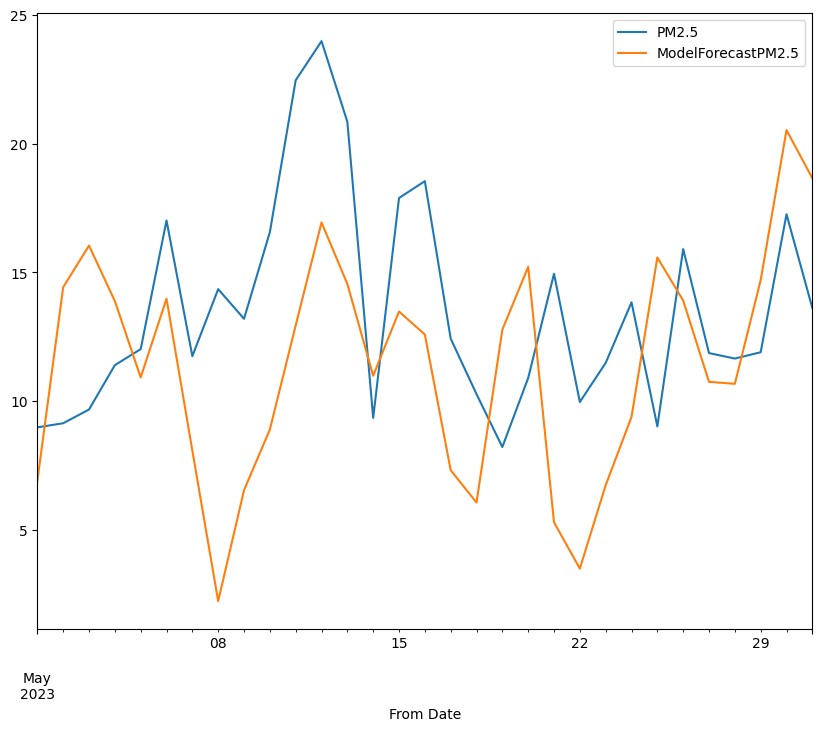

In [826]:
actualForecast[['PM2.5','ModelForecastPM2.5']].plot()


RMSE =  5.516687788684689
Mean =  11.434987176772285
MAPE =  0.6484272327704717
R2 Score =  -0.866324909824101


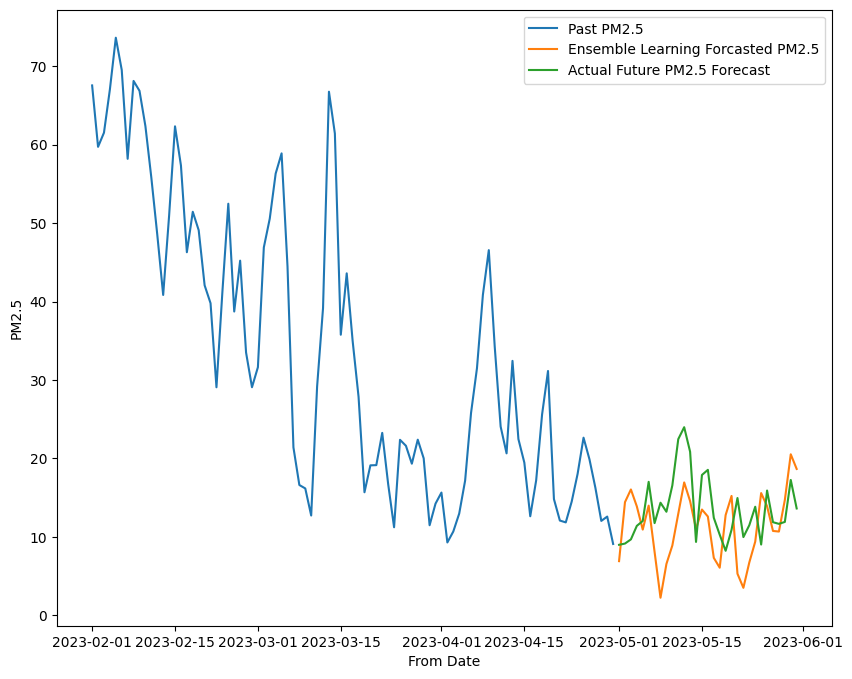

In [827]:
import seaborn as sns

forcastAQI = actualForecast[['PM2.5']]
trueAqi = actualForecast[['ModelForecastPM2.5']]

original = final_df[['From Date', 'PM2.5']]
original['From Date']=pd.to_datetime(original['From Date'])
original = original.loc[original['From Date'] >= '2023-02-01']

sns.lineplot(x=original['From Date'], y=original['PM2.5'], label = 'Past PM2.5')
sns.lineplot(x=actualForecast.index, y=actualForecast['ModelForecastPM2.5'],label = 'Ensemble Learning Forcasted PM2.5')
sns.lineplot(x=actualForecast.index, y=actualForecast['PM2.5'],label = 'Actual Future PM2.5 Forecast')
# sns.lineplot(x=true_forecast1['From Date'], y=true_forecast1['Residual'],label = 'Original Residual')
# plt.xticks(rotation=25)

forecast_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',forecast_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

#### Calculate PM10 Predictions

In [828]:
trend_pred,seasonal_pred,residual_pred

(            PM2.5_Trend  PM10_Trend       Trend  Aqi_Trend_Pred  \
 From Date                                                         
 2022-09-30    18.713086   41.652687   91.827020       89.270271   
 2022-10-01    20.474911   44.557136   97.037472       95.821518   
 2022-10-02    22.156701   46.737050  101.232835      101.657890   
 2022-10-03    23.563752   48.231358  104.175279      106.098038   
 2022-10-04    24.587245   49.289925  105.940637      108.723717   
 ...                 ...         ...         ...             ...   
 2023-04-26    14.721583   44.256946   61.373648       61.467911   
 2023-04-27    14.191181   42.608305   60.338300       60.308678   
 2023-04-28    13.822022   41.320361   59.494338       59.496895   
 2023-04-29    13.578726   40.366265   58.845542       59.053013   
 2023-04-30    13.377154   39.691484   58.414155       58.885315   
 
             PM10_Trend_Pred  PM2.5_Trend_Pred  
 From Date                                      
 2022-09-30     

In [829]:
pm10pred = trend_pred['PM10_Trend_Pred'] + seasonal_pred['PM10_Seasonal_Pred'] + residual_pred['PM10_residual_Pred']
# pm10pred = trend_pred['PM10_Trend_Pred']

In [830]:
actual = final_df.iloc[-213:]
actual = actual[['From Date','PM10']]
actual.set_index('From Date',inplace = True)

In [831]:
actual['PM10_Pred'] = pm10pred

<Axes: xlabel='From Date'>

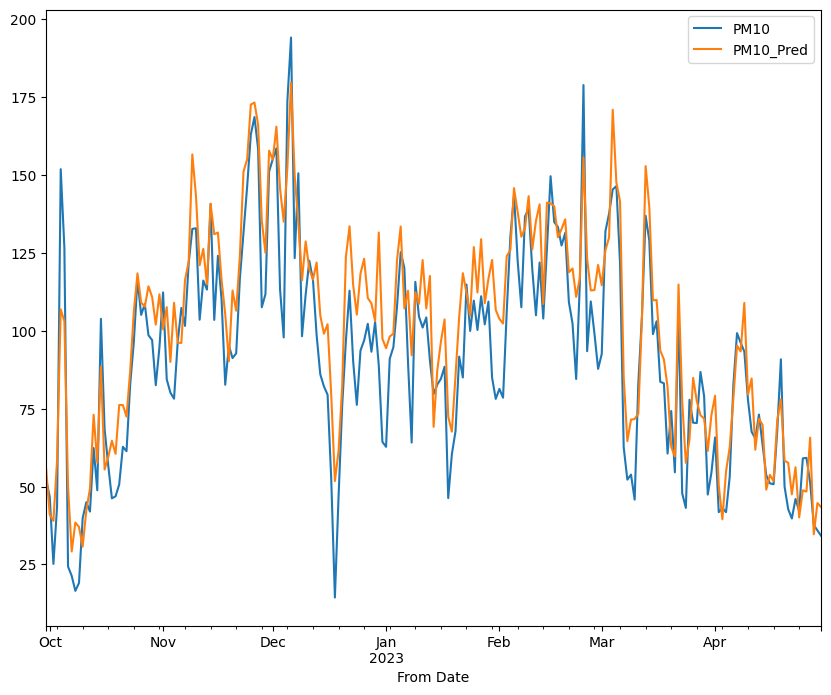

In [832]:
actual[['PM10','PM10_Pred']].plot()

In [833]:
trueAqi = actual['PM10']

forcastAQI = actual['PM10_Pred']

test_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',test_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)

RMSE =  16.52279346000809
Mean =  91.09790856248603
MAPE =  0.19245979745606068
R2 Score =  0.7570781042356218


#### PM10 Forecasting

In [834]:
# Forecast
actualTrendForecast,actualSeasonalForecast,actualResidualForecast

(            PM2.5_Trend  PM10_Trend      Trend  PM2.5TrendPred  \
 From Date                                                        
 2023-05-01    13.155412   39.282665  58.254823       12.076120   
 2023-05-02    12.948058   39.339431  58.507594       11.799791   
 2023-05-03    12.847072   40.101633  59.253273       11.394586   
 2023-05-04    12.921078   41.652313  60.437349       11.022107   
 2023-05-05    13.173533   43.871209  61.938730       10.722066   
 2023-05-06    13.594521   46.578539  63.660502       10.485122   
 2023-05-07    14.148716   49.510978  65.488080       10.295155   
 2023-05-08    14.750715   52.301756  67.230965       10.159894   
 2023-05-09    15.291200   54.639932  68.683196       10.072941   
 2023-05-10    15.676743   56.341459  69.752354       10.033140   
 2023-05-11    15.865417   57.366733  70.450389       10.032293   
 2023-05-12    15.877921   57.781077  70.835969       10.062420   
 2023-05-13    15.744836   57.619219  70.938878       10.11421

In [835]:
actualForecast = true_forecast1
actualForecast = actualForecast[['From Date','PM2.5','PM10','AQI_calculated']]
actualForecast.set_index('From Date',inplace = True)

In [836]:
actualForecast['ModelForecastPM10'] = actualTrendForecast['PM10_Trend_Pred']+actualSeasonalForecast['PM10_Seasonal_Pred'] + actualResidualForecast['PM10_Residual_Pred']
actualForecast

PM2.5        PM10  AQI_calculated  ModelForecastPM10
From Date                                                           
2023-05-01   8.983333   33.045000       58.166667          35.285010
2023-05-02   9.143333   24.573333       46.833333          45.577792
2023-05-03   9.675000   25.560000       42.000000          41.644828
2023-05-04  11.398333   30.735000       42.666667          42.251658
2023-05-05  12.020000   41.635000       94.166667          42.534680
2023-05-06  17.013333   41.606667       68.000000          40.399305
2023-05-07  11.748333   30.931667       52.000000          23.663393
2023-05-08  14.350000   43.336667       59.333333          14.794694
2023-05-09  13.198333   53.400000       64.166667          31.472421
2023-05-10  16.560000   65.871667       68.666667          33.219177
2023-05-11  22.456667  107.916667      102.833333          50.784512
2023-05-12  23.978333  101.656667       95.666667          52.105419
2023-05-13  20.848333   75.493333       82.500000          50.604555
2023-05-14   9.351667   48.073333       59.333333          43.339798
2023-05-15  17.886667   49.935000       57.333333          47.103957
2023-05-16  18.541667   54.310000       69.666667          35.299501
2023-05-17  12.430000   37.678333       66.500000          32.329661
2023-05-18  10.273333   36.515000       62.500000          25.442044
2023-05-19   8.220000   37.013333       61.166667          35.098369
2023-05-20  10.900000   31.048333       67.833333          38.335870
2023-05-21  14.946667   42.065000       65.166667          20.973035
2023-05-22   9.968333   39.338333       64.500000          21.041880
2023-05-23  11.485000   42.463333       68.666667          28.905932
2023-05-24  13.838333   38.911667       66.000000          34.070144
2023-05-25   9.020000   27.606667       69.000000          45.318085
2023-05-26  15.903333   54.185000       76.333333          42.228751
2023-05-27  11.866667   38.270000       61.666667          36.445110
2023-05-28  11.655000   34.270000       62.166667          34.731703
2023-05-29  11.900000   46.108333       67.500000          46.431827
2023-05-30  17.256667   48.786667      109.166667          53.342622
2023-05-31  13.616667   52.098333       80.666667          43.512061

<Axes: xlabel='From Date'>

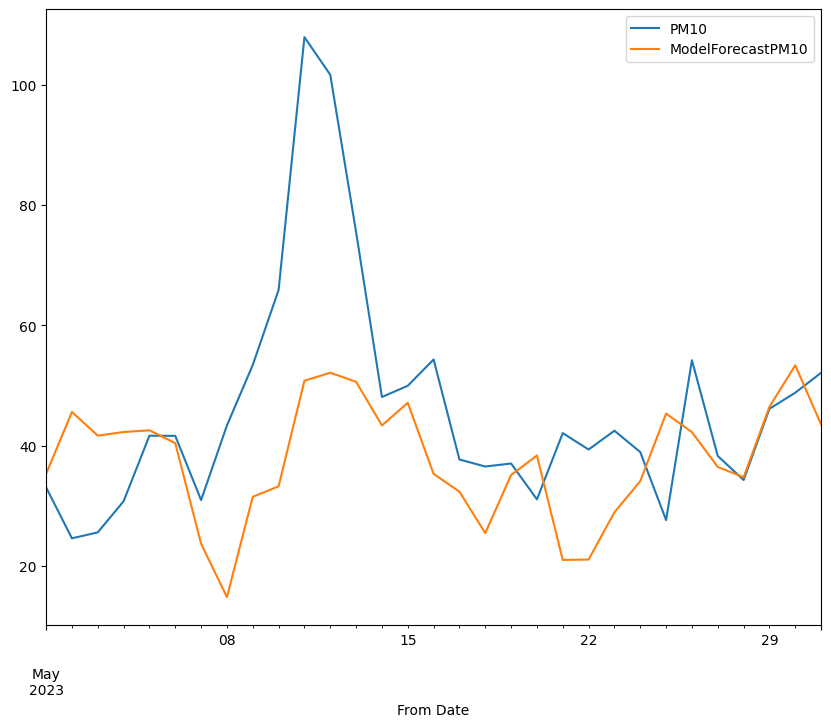

In [837]:
actualForecast[['PM10','ModelForecastPM10']].plot()


RMSE =  19.456011112000773
Mean =  37.68670301044226
MAPE =  0.41240451958290664
R2 Score =  -0.055139917673523886


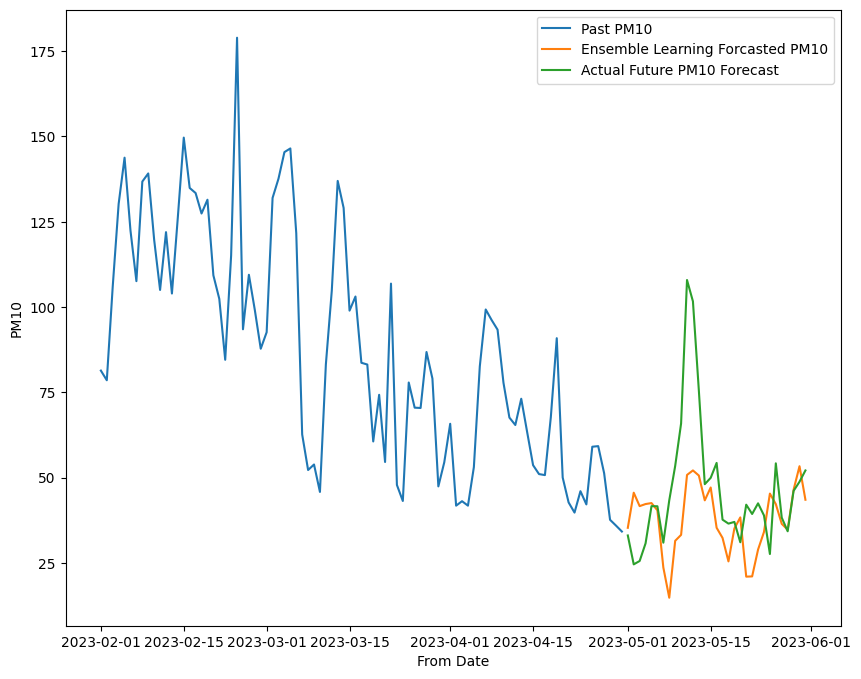

In [838]:
import seaborn as sns

forcastAQI = actualForecast[['PM10']]
trueAqi = actualForecast[['ModelForecastPM10']]

original = final_df[['From Date', 'PM10']]
original['From Date']=pd.to_datetime(original['From Date'])
original = original.loc[original['From Date'] >= '2023-02-01']

sns.lineplot(x=original['From Date'], y=original['PM10'], label = 'Past PM10')
sns.lineplot(x=actualForecast.index, y=actualForecast['ModelForecastPM10'],label = 'Ensemble Learning Forcasted PM10')
sns.lineplot(x=actualForecast.index, y=actualForecast['PM10'],label = 'Actual Future PM10 Forecast')
# sns.lineplot(x=true_forecast1['From Date'], y=true_forecast1['Residual'],label = 'Original Residual')
# plt.xticks(rotation=25)

forecast_rmse=np.sqrt(mean_squared_error(forcastAQI,trueAqi))
mape = mean_absolute_percentage_error(trueAqi, forcastAQI)
r2 = r2_score(forcastAQI,trueAqi)

print('RMSE = ',forecast_rmse)
print('Mean = ',float(trueAqi.mean()))
print("MAPE = ", mape)
print("R2 Score = ", r2)